# HCA Coding Test
## Predicting Readmission Risk of Diabetes Patients

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score, GridSearchCV,KFold,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

import xgboost as xgb
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import warnings
#warnings.filterwarnings('ignore')
%matplotlib inline

### Data Set Information:

The dataset represents 10 years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks. It includes over 50 features representing patient and hospital outcomes. Information was extracted from the database for encounters that satisfied the following criteria.
(1) It is an inpatient encounter (a hospital admission).
(2) It is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
(3) The length of stay was at least 1 day and at most 14 days.
(4) Laboratory tests were performed during the encounter.
(5) Medications were administered during the encounter.
The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.
'101,766 encounters were identified to fulfill all of the above five inclusion criteria and were used in further analysis.'

Feature dictionary "https://www.hindawi.com/journals/bmri/2014/781670/tab1/"
https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

Relevant Papers:
Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.

'Almost 70,000 inpatient diabetes encounters were identified with sufficient detail for analysis. Multivariable logistic regression was used to fit the relationship between the measurement of HbA1c and early readmission while controlling for covariates such as demographics, severity and type of the disease, and type of admission. Results show that the measurement of HbA1c was performed infrequently (18.4%) in the inpatient setting. The statistical model suggests that the relationship between the probability of readmission and the HbA1c measurement depends on the primary diagnosis. The data suggest further that the greater attention to diabetes reflected in HbA1c determination may improve patient outcomes and lower cost of inpatient care.'


'The original database contains incomplete, redundant, and noisy information as expected in any real-world data. There were several features that could not be treated directly since they had a high percentage of missing values. These features were weight (97% values missing), payer code (40%), and medical specialty (47%). Weight attribute was considered to be too sparse and it was not included in further analysis. Payer code was removed since it had a high percentage of missing values and it was not considered relevant to the outcome. Medical specialty attribute was maintained, adding the value “missing” in order to account for missing values.'

'The preliminary dataset contained multiple inpatient visits for some patients and the observations could not be considered as statistically independent, an assumption of the logistic regression model. We thus used only one encounter per patient; in particular, we considered only the first encounter for each patient as the primary admission and determined whether or not they were readmitted within 30 days. Additionally, we removed all encounters that resulted in either discharge to a hospice or patient death, to avoid biasing our analysis. After performing the above-described operations, we were left with 69,984 encounters that constituted the final dataset for analysis.'


## Step 1: Obtain data and create a DataFrame

In [2]:
#file=open(r 'https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip')
from io import BytesIO
from zipfile import ZipFile
import requests

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00296/dataset_diabetes.zip"
content = requests.get(url)
zf = ZipFile(BytesIO(content.content))

for item in zf.namelist():
    print("File in zip: "+  item)

# find the first matching csv file in the zip:
match = [s for s in zf.namelist() if ".csv" in s][0]
df = pd.read_csv(zf.open(match), low_memory=False)
match = [s for s in zf.namelist() if ".csv" in s][1]
dfid = pd.read_csv(zf.open(match), low_memory=False)
dfa=df.copy()
dfa.head()

File in zip: dataset_diabetes/diabetic_data.csv
File in zip: dataset_diabetes/IDs_mapping.csv


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
dfa.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


# Finding How many rows and columns in the full dataset

In [4]:
nrow, ncol = dfa.shape
print('There are ', nrow, ' rows and ', ncol, ' columns in the dataset')

There are  101766  rows and  50  columns in the dataset


In [5]:
dfid.describe()

,admission_type_id,description
count,65,62
unique,32,58
top,8,Not Available
freq,3,2


In [6]:
dfa.keys()

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

# Pop distribution by geneder in the full dataset

In [7]:
dfa['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [8]:
Female_Count, Male_Count, Unknown = dfa['gender'].value_counts()
print('There are ', Female_Count, ' females and ', Male_Count, ' males in the dataset')

There are  54708  females and  47055  males in the dataset


# Race distribution in the full dataset

In [9]:
a,b,c,d,e,f = dfa.race.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
print('Percentage of African Americans is', b, 'in the full dataset')

Percentage of African Americans is 18.9% in the full dataset


In [10]:
dfa.race.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Caucasian          74.8%
AfricanAmerican    18.9%
?                   2.2%
Hispanic            2.0%
Other               1.5%
Asian               0.6%
Name: race, dtype: object

# Avg Age of Females and Males in the full dataset

In [11]:
#Since age is in ranges, we can find approximate ages by gender by picking range mid-points.

In [12]:
#Explore age by gender
dfa.groupby('gender').age.value_counts()

gender           age     
Female           [70-80)     13985
                 [60-70)     11061
                 [80-90)     10515
                 [50-60)      8572
                 [40-50)      4811
                 [30-40)      2162
                 [90-100)     2003
                 [20-30)      1114
                 [10-20)       402
                 [0-10)         83
Male             [70-80)     12081
                 [60-70)     11421
                 [50-60)      8684
                 [80-90)      6682
                 [40-50)      4874
                 [30-40)      1613
                 [90-100)      790
                 [20-30)       543
                 [10-20)       289
                 [0-10)         78
Unknown/Invalid  [70-80)         2
                 [60-70)         1
Name: age, dtype: int64

In [13]:
#Step1: create a dic to bin age brackets by min & max of the bracket range
age_binned1 = {'[0-10)':0, '[10-20)':10, '[20-30)':20, '[30-40)':30, '[40-50)':40, '[50-60)':50,
       '[60-70)':60, '[70-80)':70, '[80-90)':80, '[90-100)':90}

age_binned2 = {'[0-10)':10, '[10-20)':20, '[20-30)':30, '[30-40)':40, '[40-50)':50, '[50-60)':60,
       '[60-70)':70, '[70-80)':80, '[80-90)':90, '[90-100)':100}

age_binned3 = {'[0-10)':5, '[10-20)':15, '[20-30)':25, '[30-40)':35, '[40-50)':45, '[50-60)':55,
       '[60-70)':65, '[70-80)':75, '[80-90)':85, '[90-100)':95}

dfa.age.replace(age_binned3, inplace=True)
#Step 2: replace avg age values and groupby gender to find avg age by gender
F,M,U = dfa.age.groupby([dfa.gender]).mean().round(1) 
print('Approximate average age for females is', F, 'and for males is ', M, 'in the full dataset')

Approximate average age for females is 66.7 and for males is  65.1 in the full dataset


# features with > 50% missing in the full dataset

#### There are no missing data per se

In [14]:
#another check on missing data
total = dfa.isnull().sum().sort_values(ascending=False)
percent = (dfa.isnull().sum()/dfa.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(50)

,Total,Percent
readmitted,0,0.0
num_lab_procedures,0,0.0
max_glu_serum,0,0.0
number_diagnoses,0,0.0
diag_3,0,0.0
diag_2,0,0.0
diag_1,0,0.0
number_inpatient,0,0.0
number_emergency,0,0.0
number_outpatient,0,0.0


#### However, there are fields with '?' character standing for missing or not available

#### Features with '?' character at 50% or more 

In [15]:
dfa.replace({'Missing':np.nan}, inplace=True)
a=dfa.isnull().sum(axis=0)[dfa.isnull().sum(axis=0)/len(dfa) > 0.5]
b=(a/len(dfa)).mul(100).round(2).astype(str) + '%'
print('List of features with more than 50% missing values includes:', b, 'only.')

List of features with more than 50% missing values includes: Series([], dtype: object) only.


#### List of all features with '?' missing values replaced with NAN
weight               96.86%
payer_code           39.56%
medical_specialty    49.08%
diag_3                 1.4%
race                  2.23%

# function to remove features with have a high proportion of missing values from the full dataset

##### drop features with high proportion of missing values
#missing_threshold = 0.5 # threshold leading to only 'weight' to be dropped. 
#if set at .4 Medical specialty will be dropped as well, however, it is kept given managment interest in its role in
#readmitting < 30 days, which is the target for the modeling project

In [16]:
def drop_features(df, missing_threshold):
   
    features_to_drop = df.isnull().sum(axis=0)[df.isnull().sum(axis=0)/len(df) > missing_threshold].keys().tolist()
    df.drop(features_to_drop, axis=1, inplace=True)
   
    return print('dropped feature:',features_to_drop, 'at missing threshold of:',missing_threshold, ',Dataset dimension', df.shape)
drop_features(dfa, .5)

dropped feature: [] at missing threshold of: 0.5 ,Dataset dimension (101766, 50)


# Readmitted patients in less than 30 days by Medical Specialty in the full dataset

In [17]:
dfa.readmitted.value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [18]:
dfa.medical_specialty.replace({np.nan:'Missing'}, inplace=True)
dfa[dfa.readmitted == '<30'].medical_specialty.value_counts()
#dfa[dfa.readmitted == '>30'].medical_specialty.value_counts()
#dfa[dfa.readmitted == 'NO'].medical_specialty.value_counts()

?                                       5781
InternalMedicine                        1646
Family/GeneralPractice                   883
Emergency/Trauma                         846
Cardiology                               425
Surgery-General                          342
Nephrology                               248
Orthopedics                              151
Psychiatry                               104
Radiologist                              103
Pulmonology                               96
Orthopedics-Reconstructive                92
Surgery-Vascular                          74
Urology                                   68
Oncology                                  66
Gastroenterology                          62
PhysicalMedicineandRehabilitation         60
Surgery-Cardiovascular/Thoracic           43
Hematology/Oncology                       40
ObstetricsandGynecology                   32
Surgery-Neuro                             32
Hematology                                26
Pediatrics

In [19]:
#Answer: Internal Medicine specialty is correlated with highest incidens of patients readmitted within 30 days.
#However, Internist are also highly associated with the other two categoris (>30 and NO) which might indicate that
#this correlation simply reflect that internist are more closely identified with hospital admission and tend to 
#supervise the bulk of inpatients. Also, notice 'Missing' category is by far the biggest one pointing to the need for
#better data collection to improve our understanding of the readmission incidents in <30 days from discharge.

## Step 2: Explore, Prep, Clean Data & Drop features

## Step 2.1: Select target population

### Check for Duplicates

In [20]:
#encounter_id is the unique key
dfa.encounter_id.nunique()

101766

In [21]:
dfa.patient_nbr.nunique()

71518

#### there are 30,248 duplicate patients due to multiple inpatient visits. the modeling dataset will follow the similar approach as the research paper: 'After performing the above-described operations, we were left with 69,984 encounters that constituted the final dataset for analysis.' To follow the paper, data set will by sorted by patient_id and first number_inpatient and only first instant is kept.

In [22]:
#number_inpatient analysis
dfa.number_inpatient.value_counts()

0     67630
1     19521
2      7566
3      3411
4      1622
5       812
6       480
7       268
8       151
9       111
10       61
11       49
12       34
13       20
14       10
15        9
16        6
19        2
17        1
18        1
21        1
Name: number_inpatient, dtype: int64

In [23]:
dfb=dfa.sort_values(['patient_nbr','number_inpatient'], ascending=[True, True])
dfb[['patient_nbr','number_inpatient']]

,patient_nbr,number_inpatient
4267,135,0
4780,135,1
5827,378,0
67608,729,0
17494,774,0
...,...,...
99863,189351095,0
95282,189365864,0
93651,189445127,0
101748,189481478,0


In [24]:
dfb.drop_duplicates(subset='patient_nbr', keep='first', inplace=True)
dfb.shape

(71518, 50)

#### As in the research paper, drop expired (dead) and hospice patients with discharge codes = [11,13,14]
#### 69,984 is rows in research paper's dataset. Close enough with a dif of 1 obs 

In [25]:
dfb=dfb.drop(dfb[(dfb['discharge_disposition_id'] == 11)].index)
dfb=dfb.drop(dfb[(dfb['discharge_disposition_id'] == 13)].index)
dfb=dfb.drop(dfb[(dfb['discharge_disposition_id'] == 14)].index)
dfb.shape

(69983, 50)

#### Change Data types

In [26]:
dfb['discharge_disposition_id'] = dfb['discharge_disposition_id'].astype('str')

# Exploring the modeling dataset

## How many rows and columns

In [27]:
nrow, ncol = dfb.shape
print('There are ', nrow, ' rows and ', ncol, ' columns in the dataset')

There are  69983  rows and  50  columns in the dataset


## Geneder distribution

In [28]:
dfb['gender'].value_counts()

Female             37236
Male               32744
Unknown/Invalid        3
Name: gender, dtype: int64

In [29]:
Female_Count, Male_Count, Unknown = dfb['gender'].value_counts()
print('There are ', Female_Count, ' females and ', Male_Count, ' males in the dataset')

There are  37236  females and  32744  males in the dataset


## Race distribution in the modeling dataset

In [30]:
a,b,c,d,e,f= dfb.race.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'
print('Percentage of African Americans is', b, 'in the dataset')

Percentage of African Americans is 18.0% in the dataset


In [31]:
# missing values no longer present
dfb.race.value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Caucasian          74.7%
AfricanAmerican    18.0%
?                   2.7%
Hispanic            2.1%
Other               1.6%
Asian               0.7%
Name: race, dtype: object

## Avg age by gender in modeling dataset

In [32]:
F,M,U = dfb.age.groupby([dfb.gender]).mean().round(1) 
print('Approximate average age for females is', F, 'and for males is ', M, 'in the dataset')

Approximate average age for females is 66.2 and for males is  64.6 in the dataset


## features with > 50% missing in modeling dataset

In [33]:
dfb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69983 entries, 4267 to 96147
Data columns (total 50 columns):
encounter_id                69983 non-null int64
patient_nbr                 69983 non-null int64
race                        69983 non-null object
gender                      69983 non-null object
age                         69983 non-null int64
weight                      69983 non-null object
admission_type_id           69983 non-null int64
discharge_disposition_id    69983 non-null object
admission_source_id         69983 non-null int64
time_in_hospital            69983 non-null int64
payer_code                  69983 non-null object
medical_specialty           69983 non-null object
num_lab_procedures          69983 non-null int64
num_procedures              69983 non-null int64
num_medications             69983 non-null int64
number_outpatient           69983 non-null int64
number_emergency            69983 non-null int64
number_inpatient            69983 non-null int64


In [34]:
a=dfb.isnull().sum(axis=0)[dfb.isnull().sum(axis=0)/len(dfb) > 0.5]
b=(a/len(dfb)).mul(100).round(2).astype(str) + '%'
print('List of features with more than 50% missing values includes:', b, 'only.')

List of features with more than 50% missing values includes: Series([], dtype: object) only.


In [35]:
# weight feature was dropped earlier.

## Drop features with high missing values from modeling dataset

In [36]:
def drop_features(df, missing_threshold):
   
    features_to_drop = df.isnull().sum(axis=0)[df.isnull().sum(axis=0)/len(df) > missing_threshold].keys().tolist()
    df.drop(features_to_drop, axis=1, inplace=True)
   
    return print('dropped feature:',features_to_drop, 'at missing threshold of:',missing_threshold, ',Dataset dimension', df.shape)
drop_features(dfb, .5)

dropped feature: [] at missing threshold of: 0.5 ,Dataset dimension (69983, 50)


In [37]:
# weight feature was dropped earlier.

## Readmitted patients in < 30 days by Medical Specialty in modeling dataset

In [38]:
dfb['readmitted'].value_counts()

NO     41391
>30    22132
<30     6460
Name: readmitted, dtype: int64

In [39]:
dfb[dfb.readmitted == '<30'].medical_specialty.value_counts()
#dfb[dfb.readmitted == '>30'].medical_specialty.value_counts()
#dfb[dfb.readmitted == 'NO'].medical_specialty.value_counts()

?                                       3247
InternalMedicine                        1038
Family/GeneralPractice                   490
Emergency/Trauma                         358
Cardiology                               311
Surgery-General                          181
Orthopedics                              115
Nephrology                                88
Radiologist                               69
Orthopedics-Reconstructive                69
Psychiatry                                65
Pulmonology                               64
Gastroenterology                          43
Surgery-Vascular                          41
Urology                                   40
Oncology                                  37
Surgery-Cardiovascular/Thoracic           29
PhysicalMedicineandRehabilitation         25
Hematology/Oncology                       22
ObstetricsandGynecology                   22
Surgery-Neuro                             21
Pediatrics                                11
Neurology 

In [40]:
#Comment: Internal Medicine specialty is correlated with highest incidens of patients readmitted within 30 days.
#However, Internist are also highly associated with the other two categoris (>30 and NO) which might indicate that
#this correlation simply reflect that internist are more closely identified with hospital admission and tend to 
#supervise the bulk of inpatients. 

## Step 4: Define Target (Dependent Variable - y)

In [41]:
dfb=pd.get_dummies(dfb, columns=['readmitted'])
dfb.rename(columns={"readmitted_<30": "readmitted_d"}, inplace=True)
drop=['readmitted_>30','readmitted_NO']
dfb.drop(drop, axis=1, inplace=True)
dfb.shape

(69983, 50)

In [42]:
dfb.readmitted_d.value_counts()

0    63523
1     6460
Name: readmitted_d, dtype: int64

## Step 5: drop features and convert others for using in modeling

In [43]:
#Convert some features into Dummy_vars. Features selected with high info potential based on value distribution where 
#no one value account for more than 95% of observations
#Drop feautures with little info: over 98% distribution is one value, like 'NO'
dfc=pd.get_dummies(dfb, columns=['diabetesMed','change','insulin','glipizide','glyburide','metformin','A1Cresult',
'discharge_disposition_id','admission_type_id','race','medical_specialty','diag_1'])

#dfc=pd.get_dummies(dfb, columns=[])
dfc.shape

(69983, 864)

In [44]:
dfc.keys()

Index(['encounter_id', 'patient_nbr', 'gender', 'age', 'weight',
       'admission_source_id', 'time_in_hospital', 'payer_code',
       'num_lab_procedures', 'num_procedures',
       ...
       'diag_1_V54', 'diag_1_V55', 'diag_1_V56', 'diag_1_V57', 'diag_1_V58',
       'diag_1_V60', 'diag_1_V63', 'diag_1_V67', 'diag_1_V70', 'diag_1_V71'],
      dtype='object', length=864)

In [45]:
drop_features=[
   'payer_code','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone',
     'glyburide-metformin','acarbose','miglitol','troglitazone','troglitazone',
     'tolazamide','examide','citoglipton','tolbutamide','acetohexamide','nateglinide',
     'diabetesMed_No','change_Ch','A1Cresult_>7', 'metformin_Down',
     'insulin_Down','glyburide_Down', 'glipizide_Down','diag_1_V71','race_Asian','medical_specialty_Urology',
     'discharge_disposition_id_20','admission_type_id_4'
       ]
dfc.drop(drop_features, axis=1, inplace=True)
dfc.rename(columns={"A1Cresult_>8": "A1Cresult_8"}, inplace=True)
dfc.shape

(69983, 838)

In [46]:
#Convert categorical variable to numerical variable
#    num_encode = {'col_1' : {'YES':1, 'NO':0},
#                  'col_2'  : {'WON':1, 'LOSE':0, 'DRAW':0}}  
###    df.replace(num_encode, inplace=True)  

In [47]:
# create a mapping from Admission Type label value to fruit name to make results easier to interpret
#lookup_name = dict(zip(df.feature_label.unique(), df.feature.unique()))   
#lookup_name

### Selecting features/dependent var and spliting modeling data into Test & Train

In [48]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69983 entries, 4267 to 96147
Columns: 838 entries, encounter_id to diag_1_V70
dtypes: int64(12), object(11), uint8(815)
memory usage: 67.2+ MB


In [49]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [51]:
#pd.merge(df1, df2, left_on='id', right_on='id1', how='left').drop('id1', axis=1))

# Codes to produce the modeling dataset Xcd are at the bottom of this notebook. 

In [54]:
ycd = dfc.readmitted_d
Xcd_train, Xcd_test, ycd_train, ycd_test = train_test_split(Xcd, ycd, random_state=0)

In [57]:
Xcd_train.shape, Xcd_test.shape, ycd_train.shape, ycd_test.shape

((52487, 820), (17496, 820), (52487,), (17496,))

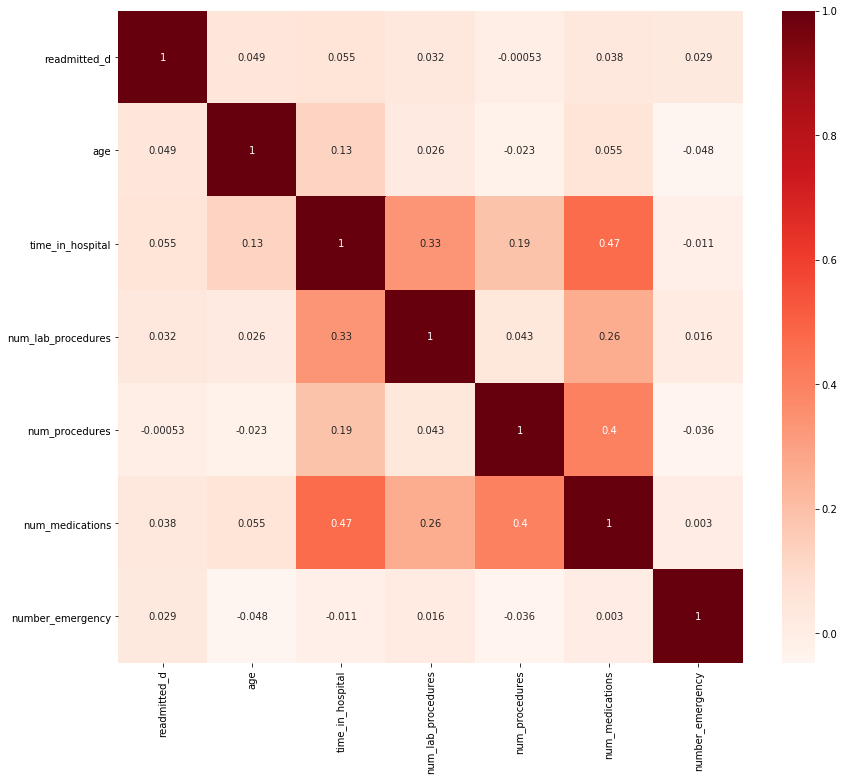

In [104]:
#Analyze Using Pearson Correlation
plt.figure(figsize=(14,12))
Xn=dfd[[ 'readmitted_d','age', 'time_in_hospital', 'num_lab_procedures','num_procedures',
        'num_medications','number_emergency',]]
cor = Xn.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [58]:
ycd_train.value_counts(), ycd_test.value_counts()

(0    47663
 1    4824 
 Name: readmitted_d, dtype: int64, 0    15860
 1    1636 
 Name: readmitted_d, dtype: int64)

In [ ]:
#scaler = MinMaxScaler()
#X_train_scaled = scaler.fit_transform(X_train)
# we must apply the scaling to the test set that we computed for the training set
#X_test_scaled = scaler.transform(X_test)

## Step 6: Modeling Approach and Fitting

#### The significant pairwise interactions between the covariates were discharge disposition with race (), medical specialty of the admitting physician (), primary diagnosis (), and time in hospital (); the specialty of the admitting physician with time in hospital () and age (); and the primary diagnosis with time in the hospital () and HbA1c (). Only these interactions were included in the final model.

### Benchmark Model Fit & Performance - Logistic Regression

In [60]:
model_lrcd = LogisticRegression(C=50).fit(Xcd_train, ycd_train)
#plot_class_regions_for_classifier_subplot(model_lr, Xc_train, y_train, None, None, 'Logistic regression \ for binary classification', subaxes)
model_lrcd.predict(Xcd_train)
lr_predcd=model_lrcd.predict(Xcd_test)
print( confusion_matrix(ycd_test, model_lrcd.predict(Xcd_test)))
print(classification_report(ycd_test, lr_predcd, target_names=['0', '1']))

/Users/zaidalbarzinji/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[15859     1]
 [ 1636     0]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     15860
           1       0.00      0.00      0.00      1636

    accuracy                           0.91     17496
   macro avg       0.45      0.50      0.48     17496
weighted avg       0.82      0.91      0.86     17496



In [62]:
model_lrcd.coef_

array([[ 4.29758996e-03,  2.29612288e-02,  2.56246127e-03,
        -1.18022344e-02,  6.10124843e-04,  1.22671880e-01,
         1.41603416e-02,  2.49276059e-03, -1.85589472e-02,
        -6.26462498e-03,  6.59255970e-03, -1.58329923e-01,
        -1.39825378e-02, -8.39966258e-05,  0.00000000e+00,
         7.04633797e-02,  4.40548462e-03, -9.53703225e-04,
        -1.34067992e-03, -3.67834833e-04, -2.73072662e-03,
         1.53039805e-02,  2.77410706e-02,  8.81625318e-03,
        -3.64016299e-01, -2.72371860e-03,  1.74120809e-03,
        -3.77268347e-04, -2.76301143e-03, -3.18365174e-02,
         7.72321168e-03, -7.32211881e-04,  6.33430863e-02,
        -2.29694035e-01, -3.85702865e-04,  1.34004274e-02,
         0.00000000e+00, -4.61289200e-04, -3.20965169e-03,
         2.84178171e-02, -3.51301793e-02, -2.74485242e-02,
        -1.32084823e-01,  4.27722561e-03,  7.96254836e-03,
        -8.12022095e-04,  0.00000000e+00, -3.11168015e-03,
         5.23097273e-03, -2.18087581e-03, -4.25723896e-0

### Challenger Models Fit & Performance (A. DNN, B. XGBoost Tree & 3. Kernalized SVA) /H2O-AutoML (?)

In [63]:
title = 'Random Forest Classifier, default settings, with Xcd features'
model_rf2cd = RandomForestClassifier().fit(Xcd_train, ycd_train)
model_rf2cd.predict(Xcd_train)
rf_pred2cd=model_rf2cd.predict(Xcd_test)
print(confusion_matrix(ycd_test, rf_pred2cd))
print(classification_report(ycd_test, rf_pred2cd, target_names=['0', '1']))

[[15851     9]
 [ 1628     8]]
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     15860
           1       0.47      0.00      0.01      1636

    accuracy                           0.91     17496
   macro avg       0.69      0.50      0.48     17496
weighted avg       0.87      0.91      0.86     17496



### Balance the modeling dataset by oversampling the target value

In [64]:
# import SMOTE module from imblearn library 
# pip install imblearn (if you don't have imblearn in your system) 
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 0) 
Xcd_train, ycd_train = sm.fit_sample(Xcd_train, ycd_train.ravel()) 
Xcd_train.shape, ycd_train.shape, Xcd_train.shape, ycd_train.shape

Using TensorFlow backend.


((95326, 820), (95326,), (95326, 820), (95326,))

In [ ]:
#Performance improved, especially recall and f1

### XGBoost

In [65]:
model_xgb = XGBClassifier().fit(Xcd_train, ycd_train)
model_xgb.predict(Xcd_train)
xgb_predcd=model_xgb.predict(Xcd_test)
print(confusion_matrix(ycd_test, xgb_predcd))
print(classification_report(ycd_test, xgb_predcd, target_names=['0', '1']))

[[15471   389]
 [ 1536   100]]
              precision    recall  f1-score   support

           1       0.91      0.98      0.94     15860
           0       0.20      0.06      0.09      1636

    accuracy                           0.89     17496
   macro avg       0.56      0.52      0.52     17496
weighted avg       0.84      0.89      0.86     17496



In [ ]:
model_rf.estimator_params

## H2O AutoML

In [66]:
import h2o
h2o.init()
from h2o.automl import H2OAutoML

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,9 hours 48 mins
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,3 days
H2O cluster name:,H2O_from_python_zaidalbarzinji_5hp336
H2O cluster total nodes:,1
H2O cluster free memory:,1.504 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"


In [ ]:
#balance_classes = TRUE

In [69]:
#kSplit into a t & v using dfd with 800 features
frame_dfd = h2o.H2OFrame(dfd)
dfd_train, dfd_test = frame_dfd.split_frame([0.60], seed =0)
print(dfd_train)
print(dfd_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


encounter_id patient_nbr gender age weight admission_source_id time_in_hospital num_lab_procedures num_procedures num_medications number_outpatient number_emergency number_inpatient diag_2 diag_3 number_diagnoses max_glu_serum repaglinide chlorpropamide glimepiride pioglitazone rosiglitazone metformin-pioglitazone readmitted_d diabetesMed_Yes change_No insulin_No insulin_Steady insulin_Up glipizide_No glipizide_Steady glipizide_Up glyburide_No glyburide_Steady glyburide_Up metformin_No metformin_Steady metformin_Up A1Cresult_8 A1Cresult_None A1Cresult_Norm discharge_disposition_id_1 discharge_disposition_id_10 discharge_disposition_id_12 discharge_disposition_id_15 discharge_disposition_id_16 discharge_disposition_id_17 discharge_disposition_id_18 discharge_disposition_id_19 discharge_disposition_id_2 discharge_disposition_id_22 discharge_disposition_id_23 discharge_disposition_id_24 discharge_disposition_id_25 discharge_disposition_id_27 discharge_disposition_id_28 discharge_disposition_id_3 discharge_disposition_id_4 discharge_disposition_id_5 discharge_disposition_id_6 discharge_disposition_id_7 discharge_disposition_id_8 discharge_disposition_id_9 admission_type_id_1 admission_type_id_2 admission_type_id_3 admission_type_id_5 admission_type_id_6 admission_type_id_7 admission_type_id_8 race_? race_AfricanAmerican race_Caucasian race_Hispanic race_Other medical_specialty_? medical_specialty_AllergyandImmunology medical_specialty_Anesthesiology medical_specialty_Anesthesiology-Pediatric medical_specialty_Cardiology medical_specialty_Cardiology-Pediatric medical_specialty_DCPTEAM medical_specialty_Dentistry medical_specialty_Dermatology medical_specialty_Emergency/Trauma medical_specialty_Endocrinology medical_specialty_Endocrinology-Metabolism medical_specialty_Family/GeneralPractice medical_specialty_Gastroenterology medical_specialty_Gynecology medical_specialty_Hematology medical_specialty_Hematology/Oncology medical_specialty_Hospitalist medical_specialty_InfectiousDiseases medical_specialty_InternalMedicine medical_specialty_Nephrology medical_specialty_Neurology medical_specialty_Neurophysiology medical_specialty_Obsterics&Gynecology-GynecologicOnco medical_specialty_Obstetrics medical_specialty_ObstetricsandGynecology medical_specialty_Oncology medical_specialty_Ophthalmology medical_specialty_Orthopedics medical_specialty_Orthopedics-Reconstructive medical_specialty_Osteopath medical_specialty_Otolaryngology medical_specialty_OutreachServices medical_specialty_Pathology medical_specialty_Pediatrics medical_specialty_Pediatrics-CriticalCare medical_specialty_Pediatrics-EmergencyMedicine medical_specialty_Pediatrics-Endocrinology medical_specialty_Pediatrics-Hematology-Oncology medical_specialty_Pediatrics-Neurology medical_specialty_Pediatrics-Pulmonology medical_specialty_Perinatology medical_specialty_PhysicalMedicineandRehabilitation medical_specialty_PhysicianNotFound medical_specialty_Podiatry medical_specialty_Proctology medical_specialty_Psychiatry medical_specialty_Psychiatry-Addictive medical_specialty_Psychiatry-Child/Adolescent medical_specialty_Psychology medical_specialty_Pulmonology medical_specialty_Radiologist medical_specialty_Radiology medical_specialty_Resident medical_specialty_Rheumatology medical_specialty_Speech medical_specialty_SportsMedicine medical_specialty_Surgeon medical_specialty_Surgery-Cardiovascular medical_specialty_Surgery-Cardiovascular/Thoracic medical_specialty_Surgery-Colon&Rectal medical_specialty_Surgery-General medical_specialty_Surgery-Maxillofacial medical_specialty_Surgery-Neuro medical_specialty_Surgery-Pediatric medical_specialty_Surgery-Plastic medical_specialty_Surgery-PlasticwithinHeadandNeck medical_specialty_Surgery-Thoracic medical_specialty_Surgery-Vascular medical_specialty_SurgicalSpecialty diag_1_10 diag_1_11 diag_1_110 diag_1_112 diag_1_114 diag_1_115 diag_1_117 diag_1_131 diag_1_133 diag_1_135 diag_1_136 diag_1_141 diag_1_142 diag_1_143 diag_1_145 diag_1_146 d

encounter_id patient_nbr gender age weight admission_source_id time_in_hospital num_lab_procedures num_procedures num_medications number_outpatient number_emergency number_inpatient diag_2 diag_3 number_diagnoses max_glu_serum repaglinide chlorpropamide glimepiride pioglitazone rosiglitazone metformin-pioglitazone readmitted_d diabetesMed_Yes change_No insulin_No insulin_Steady insulin_Up glipizide_No glipizide_Steady glipizide_Up glyburide_No glyburide_Steady glyburide_Up metformin_No metformin_Steady metformin_Up A1Cresult_8 A1Cresult_None A1Cresult_Norm discharge_disposition_id_1 discharge_disposition_id_10 discharge_disposition_id_12 discharge_disposition_id_15 discharge_disposition_id_16 discharge_disposition_id_17 discharge_disposition_id_18 discharge_disposition_id_19 discharge_disposition_id_2 discharge_disposition_id_22 discharge_disposition_id_23 discharge_disposition_id_24 discharge_disposition_id_25 discharge_disposition_id_27 discharge_disposition_id_28 discharge_disposition_id_3 discharge_disposition_id_4 discharge_disposition_id_5 discharge_disposition_id_6 discharge_disposition_id_7 discharge_disposition_id_8 discharge_disposition_id_9 admission_type_id_1 admission_type_id_2 admission_type_id_3 admission_type_id_5 admission_type_id_6 admission_type_id_7 admission_type_id_8 race_? race_AfricanAmerican race_Caucasian race_Hispanic race_Other medical_specialty_? medical_specialty_AllergyandImmunology medical_specialty_Anesthesiology medical_specialty_Anesthesiology-Pediatric medical_specialty_Cardiology medical_specialty_Cardiology-Pediatric medical_specialty_DCPTEAM medical_specialty_Dentistry medical_specialty_Dermatology medical_specialty_Emergency/Trauma medical_specialty_Endocrinology medical_specialty_Endocrinology-Metabolism medical_specialty_Family/GeneralPractice medical_specialty_Gastroenterology medical_specialty_Gynecology medical_specialty_Hematology medical_specialty_Hematology/Oncology medical_specialty_Hospitalist medical_specialty_InfectiousDiseases medical_specialty_InternalMedicine medical_specialty_Nephrology medical_specialty_Neurology medical_specialty_Neurophysiology medical_specialty_Obsterics&Gynecology-GynecologicOnco medical_specialty_Obstetrics medical_specialty_ObstetricsandGynecology medical_specialty_Oncology medical_specialty_Ophthalmology medical_specialty_Orthopedics medical_specialty_Orthopedics-Reconstructive medical_specialty_Osteopath medical_specialty_Otolaryngology medical_specialty_OutreachServices medical_specialty_Pathology medical_specialty_Pediatrics medical_specialty_Pediatrics-CriticalCare medical_specialty_Pediatrics-EmergencyMedicine medical_specialty_Pediatrics-Endocrinology medical_specialty_Pediatrics-Hematology-Oncology medical_specialty_Pediatrics-Neurology medical_specialty_Pediatrics-Pulmonology medical_specialty_Perinatology medical_specialty_PhysicalMedicineandRehabilitation medical_specialty_PhysicianNotFound medical_specialty_Podiatry medical_specialty_Proctology medical_specialty_Psychiatry medical_specialty_Psychiatry-Addictive medical_specialty_Psychiatry-Child/Adolescent medical_specialty_Psychology medical_specialty_Pulmonology medical_specialty_Radiologist medical_specialty_Radiology medical_specialty_Resident medical_specialty_Rheumatology medical_specialty_Speech medical_specialty_SportsMedicine medical_specialty_Surgeon medical_specialty_Surgery-Cardiovascular medical_specialty_Surgery-Cardiovascular/Thoracic medical_specialty_Surgery-Colon&Rectal medical_specialty_Surgery-General medical_specialty_Surgery-Maxillofacial medical_specialty_Surgery-Neuro medical_specialty_Surgery-Pediatric medical_specialty_Surgery-Plastic medical_specialty_Surgery-PlasticwithinHeadandNeck medical_specialty_Surgery-Thoracic medical_specialty_Surgery-Vascular medical_specialty_SurgicalSpecialty diag_1_10 diag_1_11 diag_1_110 diag_1_112 diag_1_114 diag_1_115 diag_1_117 diag_1_131 diag_1_133 diag_1_135 diag_1_136 diag_1_141 diag_1_142 diag_1_143 diag_1_145 diag_1_146 d

In [77]:
#Designate predictors and resp vars
response = 'readmitted_d'
predictors = list(Xcd_list)

# For binary classification, response should be a factor
dfd_train[response] = dfd_train[response].asfactor()
dfd_test[response] = dfd_test[response].asfactor()


In [ ]:
#aml = h2o.automl(x = x, y = y,training_frame = train,max_runtime_secs = 30)

In [92]:
amlXcd = H2OAutoML(max_models=5,  seed=0, max_runtime_secs = 600, balance_classes = True)
amlXcd.train(y=response, x=predictors, training_frame=dfd_train, validation_frame =dfd_test,
             leaderboard_frame=dfd_test)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [94]:
# View the AutoML Leaderboard
lb = amlXcd.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20191220_162345,0.639523,0.294987,0.169099,0.405987,0.284425,0.0808976
StackedEnsemble_BestOfFamily_AutoML_20191220_162345,0.637264,0.295554,0.166161,0.409002,0.284653,0.0810273
XGBoost_1_AutoML_20191220_162345,0.637253,0.294718,0.166172,0.408056,0.284397,0.0808818
XGBoost_3_AutoML_20191220_162345,0.636807,0.295218,0.167862,0.406762,0.284464,0.0809199
XGBoost_2_AutoML_20191220_162345,0.625332,0.297197,0.155989,0.422658,0.285363,0.0814323


In [96]:
#amlX.model_performance(dfh_test)
perf = amlXcd.leader.model_performance(dfd_test)
perf


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.08089759163816349
RMSE: 0.28442501936039927
LogLoss: 0.2949873415585277
Null degrees of freedom: 28027
Residual degrees of freedom: 28024
Null deviance: 17159.967241192415
Residual deviance: 16535.810418404828
AIC: 16543.810418404828
AUC: 0.6395234308482747
AUCPR: 0.16909874200610076
Gini: 0.27904686169654935

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10115391511859355: 


,,0,1,Error,Rate
0,0,19513.0,5949.0,0.2336,(5949.0/25462.0)
1,1,1484.0,1082.0,0.5783,(1484.0/2566.0)
2,Total,20997.0,7031.0,0.2652,(7433.0/28028.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.101154,0.225487,266.0
1,max f2,0.073000,0.357509,337.0
2,max f0point5,0.164156,0.221042,176.0
3,max accuracy,0.613116,0.908484,20.0
4,max precision,0.613116,0.516129,20.0
5,max recall,0.053710,1.000000,396.0
6,max specificity,0.936949,0.999921,0.0
7,max absolute_mcc,0.164156,0.132170,176.0
8,max min_per_class_accuracy,0.084334,0.596497,306.0
9,max mean_per_class_accuracy,0.091399,0.601786,288.0



Gains/Lift Table: Avg response rate:  9.16 %, avg score:  9.26 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010026,0.315550,4.081487,4.081487,0.373665,0.443876,0.373665,0.443876,0.040920,0.040920,308.148717,308.148717
1,,2,0.020016,0.240903,3.276851,3.679886,0.300000,0.274833,0.336898,0.359505,0.032736,0.073655,227.685113,267.988630
2,,3,0.030006,0.200431,2.340608,3.233991,0.214286,0.218816,0.296076,0.312665,0.023383,0.097038,134.060795,223.399101
3,,4,0.040031,0.176554,2.021308,2.930280,0.185053,0.187901,0.268271,0.281418,0.020265,0.117303,102.130793,193.027983
4,,5,0.050021,0.162842,2.262588,2.796932,0.207143,0.169251,0.256063,0.259017,0.022603,0.139906,126.258769,179.693190
5,,6,0.100007,0.129989,1.457938,2.127674,0.133476,0.142675,0.194791,0.200867,0.072876,0.212783,45.793757,112.767358
6,,7,0.150029,0.116601,1.488061,1.914419,0.136234,0.122688,0.175268,0.174801,0.074435,0.287217,48.806126,91.441877
7,,8,0.200014,0.107840,1.364380,1.776958,0.124911,0.111919,0.162683,0.159086,0.068200,0.355417,36.438008,77.695816
8,,9,0.300021,0.095519,1.227504,1.593807,0.112380,0.101217,0.145915,0.139796,0.122759,0.478176,22.750399,59.380677
9,,10,0.399993,0.086001,1.072013,1.463393,0.098144,0.090585,0.133976,0.127497,0.107171,0.585347,7.201292,46.339321


In [100]:
amlXcd.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_AutoML_20191220_162345

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.07654278904763365
RMSE: 0.27666367496950817
LogLoss: 0.2762571470504073
Null degrees of freedom: 41954
Residual degrees of freedom: 41951
Null deviance: 25928.17975095538
Residual deviance: 23180.737208999675
AIC: 23188.737208999675
AUC: 0.7670592770367931
AUCPR: 0.3196770419348471
Gini: 0.5341185540735862

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13148547839017818: 


,,0,1,Error,Rate
0,0,35277.0,2784.0,0.0731,(2784.0/38061.0)
1,1,2428.0,1466.0,0.6235,(2428.0/3894.0)
2,Total,37705.0,4250.0,0.1242,(5212.0/41955.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.131485,0.360020,219.0
1,max f2,0.095875,0.447695,282.0
2,max f0point5,0.158591,0.380024,189.0
3,max accuracy,0.336994,0.910237,95.0
4,max precision,0.925512,1.000000,0.0
5,max recall,0.053893,1.000000,394.0
6,max specificity,0.925512,1.000000,0.0
7,max absolute_mcc,0.132218,0.291966,218.0
8,max min_per_class_accuracy,0.090983,0.687344,294.0
9,max mean_per_class_accuracy,0.102253,0.692425,269.0



Gains/Lift Table: Avg response rate:  9.28 %, avg score:  9.34 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010011,0.336321,7.028927,7.028927,0.652381,0.473260,0.652381,0.473260,0.070365,0.070365,602.892729,602.892729
1,,2,0.020021,0.245806,4.874074,5.951500,0.452381,0.285052,0.552381,0.379156,0.048793,0.119158,387.407367,495.150048
2,,3,0.030008,0.207440,4.011422,5.305835,0.372315,0.224281,0.492454,0.327613,0.040062,0.159219,301.142202,430.583497
3,,4,0.040019,0.182136,3.668382,4.896228,0.340476,0.193537,0.454437,0.294074,0.036723,0.195942,266.838176,389.622785
4,,5,0.050006,0.166157,3.985708,4.714384,0.369928,0.173335,0.437560,0.269961,0.039805,0.235747,298.570777,371.438423
5,,6,0.100012,0.131525,2.752625,3.733505,0.255481,0.145321,0.346520,0.207641,0.137648,0.373395,175.262522,273.350472
6,,7,0.150018,0.117417,1.874456,3.113822,0.173975,0.123843,0.289005,0.179709,0.093734,0.467129,87.445560,211.382168
7,,8,0.200000,0.108234,1.454038,2.699024,0.134955,0.112592,0.250506,0.162935,0.072676,0.539805,45.403809,169.902414
8,,9,0.300012,0.095489,1.078454,2.158791,0.100095,0.101411,0.200365,0.142426,0.107858,0.647663,7.845391,115.879115
9,,10,0.400000,0.086099,0.878379,1.838726,0.081526,0.090631,0.170659,0.129479,0.087827,0.735490,-12.162105,83.872625




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.08089759163816349
RMSE: 0.28442501936039927
LogLoss: 0.2949873415585277
Null degrees of freedom: 28027
Residual degrees of freedom: 28024
Null deviance: 17159.967241192415
Residual deviance: 16535.810418404828
AIC: 16543.810418404828
AUC: 0.6395234308482747
AUCPR: 0.16909874200610076
Gini: 0.27904686169654935

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10115391511859355: 


,,0,1,Error,Rate
0,0,19513.0,5949.0,0.2336,(5949.0/25462.0)
1,1,1484.0,1082.0,0.5783,(1484.0/2566.0)
2,Total,20997.0,7031.0,0.2652,(7433.0/28028.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.101154,0.225487,266.0
1,max f2,0.073000,0.357509,337.0
2,max f0point5,0.164156,0.221042,176.0
3,max accuracy,0.613116,0.908484,20.0
4,max precision,0.613116,0.516129,20.0
5,max recall,0.053710,1.000000,396.0
6,max specificity,0.936949,0.999921,0.0
7,max absolute_mcc,0.164156,0.132170,176.0
8,max min_per_class_accuracy,0.084334,0.596497,306.0
9,max mean_per_class_accuracy,0.091399,0.601786,288.0



Gains/Lift Table: Avg response rate:  9.16 %, avg score:  9.26 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010026,0.315550,4.081487,4.081487,0.373665,0.443876,0.373665,0.443876,0.040920,0.040920,308.148717,308.148717
1,,2,0.020016,0.240903,3.276851,3.679886,0.300000,0.274833,0.336898,0.359505,0.032736,0.073655,227.685113,267.988630
2,,3,0.030006,0.200431,2.340608,3.233991,0.214286,0.218816,0.296076,0.312665,0.023383,0.097038,134.060795,223.399101
3,,4,0.040031,0.176554,2.021308,2.930280,0.185053,0.187901,0.268271,0.281418,0.020265,0.117303,102.130793,193.027983
4,,5,0.050021,0.162842,2.262588,2.796932,0.207143,0.169251,0.256063,0.259017,0.022603,0.139906,126.258769,179.693190
5,,6,0.100007,0.129989,1.457938,2.127674,0.133476,0.142675,0.194791,0.200867,0.072876,0.212783,45.793757,112.767358
6,,7,0.150029,0.116601,1.488061,1.914419,0.136234,0.122688,0.175268,0.174801,0.074435,0.287217,48.806126,91.441877
7,,8,0.200014,0.107840,1.364380,1.776958,0.124911,0.111919,0.162683,0.159086,0.068200,0.355417,36.438008,77.695816
8,,9,0.300021,0.095519,1.227504,1.593807,0.112380,0.101217,0.145915,0.139796,0.122759,0.478176,22.750399,59.380677
9,,10,0.399993,0.086001,1.072013,1.463393,0.098144,0.090585,0.133976,0.127497,0.107171,0.585347,7.201292,46.339321




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.0821240930430955
RMSE: 0.28657301520397116
LogLoss: 0.2981849121665091
Null degrees of freedom: 41954
Residual degrees of freedom: 41951
Null deviance: 25931.197670075257
Residual deviance: 25020.695979891778
AIC: 25028.695979891778
AUC: 0.6412771428051315
AUCPR: 0.16724498658505862
Gini: 0.28255428561026297

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10871831472999857: 


,,0,1,Error,Rate
0,0,31016.0,7045.0,0.1851,(7045.0/38061.0)
1,1,2498.0,1396.0,0.6415,(2498.0/3894.0)
2,Total,33514.0,8441.0,0.2275,(9543.0/41955.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.108718,0.226348,254.0
1,max f2,0.074218,0.363489,336.0
2,max f0point5,0.146272,0.220393,197.0
3,max accuracy,0.625259,0.907305,20.0
4,max precision,0.850658,1.000000,0.0
5,max recall,0.051619,1.000000,398.0
6,max specificity,0.850658,1.000000,0.0
7,max absolute_mcc,0.146272,0.134422,197.0
8,max min_per_class_accuracy,0.084767,0.599590,309.0
9,max mean_per_class_accuracy,0.085092,0.600794,308.0



Gains/Lift Table: Avg response rate:  9.28 %, avg score:  9.28 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010011,0.315488,3.386199,3.386199,0.314286,0.436634,0.314286,0.436634,0.033898,0.033898,238.619855,238.619855
1,,2,0.020021,0.237755,2.898791,3.142495,0.269048,0.271389,0.291667,0.354012,0.029019,0.062917,189.879118,214.249486
2,,3,0.030008,0.200491,2.494282,2.926767,0.231504,0.217226,0.271644,0.308489,0.024910,0.087827,149.428164,192.676703
3,,4,0.040019,0.177673,2.257466,2.759342,0.209524,0.188214,0.256105,0.278402,0.022599,0.110426,125.746570,175.934204
4,,5,0.050006,0.163070,2.288568,2.665322,0.212411,0.169800,0.247378,0.256713,0.022856,0.133282,128.856769,166.532180
5,,6,0.100012,0.131985,1.771746,2.218534,0.164442,0.144690,0.205910,0.200701,0.088598,0.221880,77.174571,121.853376
6,,7,0.150018,0.117863,1.396855,1.944641,0.129647,0.124159,0.180489,0.175187,0.069851,0.291731,39.685459,94.464070
7,,8,0.200000,0.108611,1.294762,1.782229,0.120172,0.112996,0.165415,0.159645,0.064715,0.356446,29.476183,78.222907
8,,9,0.300012,0.095478,1.176028,1.580146,0.109152,0.101620,0.146659,0.140302,0.117617,0.474063,17.602831,58.014610
9,,10,0.400000,0.085998,1.042754,1.445814,0.096782,0.090618,0.134191,0.127882,0.104263,0.578326,4.275396,44.581407


In [101]:
# Predict with top model from AutoML Leaderboard on a H2OFrame called 'test'
amlXcd.predict(dfd_test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,p0,p1
0,0.899691,0.100309
0,0.929497,0.0705035
0,0.929374,0.0706264
0,0.92744,0.0725602
0,0.925015,0.074985
0,0.941226,0.0587744
1,0.57924,0.42076
0,0.935773,0.0642275
0,0.917628,0.082372
0,0.944147,0.055853


In [ ]:
#RFE (Recursive Feature Elimination)
#model_RFE = LogisticRegression()
#Initializing RFE model
#rfe = RFE(model_RFE, 7)
#Transforming data using RFE
#X_rfe = rfe.fit_transform(Xc_train,y_train)  
#Fitting the data to model
#model_RFE.fit(X_rfe,y_train)
#print(rfe.support_)
#print(rfe.ranking_)

In [ ]:
#model_RFE.predict(Xc_train)
#pred_RFE=model_RFE.predict(Xc_test)

## codes used to produce modeling dataset dfd (with/without the target) & candidate feature list Xcd

In [ ]:
dfd=dfc
[[ 'readmitted_d',
    'age', 'time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 
        #'number_outpatient','number_inpatient'
       'number_emergency',
    'diabetesMed_Yes',	 'diag_1_203',	 'diag_1_416',	 'diag_1_664',	 'diag_1_972',	 'medical_specialty_Orthopedics-Reconstructive',	 'diag_1_295',	 'diag_1_536',	 'diag_1_817',
 'change_No',	 'diag_1_204',	 'diag_1_417',	 'diag_1_665',	 'diag_1_976',	 'medical_specialty_Osteopath',	 'diag_1_296',	 'diag_1_537',	 'diag_1_82',
 'insulin_No',	 'diag_1_205',	 'diag_1_42',	 'diag_1_669',	 'diag_1_977',	 'medical_specialty_Otolaryngology',	 'diag_1_297',	 'diag_1_54',	 'diag_1_820',
 'insulin_Steady',	 'diag_1_207',	 'diag_1_420',	 'diag_1_671',	 'diag_1_98',	 'medical_specialty_OutreachServices',	 'diag_1_298',	 'diag_1_540',	 'diag_1_821',
 'insulin_Up',	 'diag_1_208',	 'diag_1_421',	 'diag_1_674',	 'diag_1_980',	 'medical_specialty_Pathology',	 'diag_1_299',	 'diag_1_541',	 'diag_1_822',
 'glipizide_No',	 'diag_1_210',	 'diag_1_422',	 'diag_1_680',	 'diag_1_982',	 'medical_specialty_Pediatrics',	 'diag_1_3',	 'diag_1_542',	 'diag_1_823',
 'glipizide_Steady',	 'diag_1_211',	 'diag_1_423',	 'diag_1_681',	 'diag_1_983',	 'medical_specialty_Pediatrics-CriticalCare',	 'diag_1_300',	 'diag_1_550',	 'diag_1_824',
 'glipizide_Up',	 'diag_1_212',	 'diag_1_424',	 'diag_1_682',	 'diag_1_986',	 'medical_specialty_Pediatrics-EmergencyMedicine',	 'diag_1_301',	 'diag_1_551',	 'diag_1_825',
 'glyburide_No',	 'diag_1_214',	 'diag_1_425',	 'diag_1_683',	 'diag_1_987',	 'medical_specialty_Pediatrics-Endocrinology',	 'diag_1_303',	 'diag_1_552',	 'diag_1_826',
 'glyburide_Steady',	 'diag_1_215',	 'diag_1_426',	 'diag_1_684',	 'diag_1_989',	 'medical_specialty_Pediatrics-Hematology-Oncology',	 'diag_1_304',	 'diag_1_553',	 'diag_1_831',
 'glyburide_Up',	 'diag_1_216',	 'diag_1_427',	 'diag_1_685',	 'diag_1_990',	 'medical_specialty_Pediatrics-Neurology',	 'diag_1_305',	 'diag_1_555',	 'diag_1_832',
 'metformin_No',	 'diag_1_217',	 'diag_1_428',	 'diag_1_686',	 'diag_1_991',	 'medical_specialty_Pediatrics-Pulmonology',	 'diag_1_306',	 'diag_1_556',	 'diag_1_833',
 'metformin_Steady',	 'diag_1_218',	 'diag_1_429',	 'diag_1_690',	 'diag_1_992',	 'medical_specialty_Perinatology',	 'diag_1_307',	 'diag_1_557',	 'diag_1_834',
 'metformin_Up',	 'diag_1_219',	 'diag_1_430',	 'diag_1_691',	 'diag_1_994',	 'medical_specialty_PhysicalMedicineandRehabilitation',	 'diag_1_308',	 'diag_1_558',	 'diag_1_835',
 'A1Cresult_8',	 'diag_1_220',	 'diag_1_431',	 'diag_1_692',	 'diag_1_995',	 'medical_specialty_PhysicianNotFound',	 'diag_1_309',	 'diag_1_560',	 'diag_1_836',
 'A1Cresult_None',	 'diag_1_223',	 'diag_1_432',	 'diag_1_693',	 'diag_1_996',	 'medical_specialty_Podiatry',	 'diag_1_31',	 'diag_1_562',	 'diag_1_837',
 'A1Cresult_Norm',	 'diag_1_225',	 'diag_1_433',	 'diag_1_694',	 'diag_1_997',	 'medical_specialty_Proctology',	 'diag_1_310',	 'diag_1_564',	 'diag_1_838',
 'discharge_disposition_id_1',	 'diag_1_226',	 'diag_1_434',	 'diag_1_695',	 'diag_1_998',	 'medical_specialty_Psychiatry',	 'diag_1_311',	 'diag_1_565',	 'diag_1_839',
 'discharge_disposition_id_10',	 'diag_1_227',	 'diag_1_435',	 'diag_1_696',	 'diag_1_999',	 'medical_specialty_Psychiatry-Addictive',	 'diag_1_312',	 'diag_1_566',	 'diag_1_84',
 'discharge_disposition_id_12',	 'diag_1_228',	 'diag_1_436',	 'diag_1_7',	 'diag_1_?',	 'medical_specialty_Psychiatry-Child/Adolescent',	 'diag_1_314',	 'diag_1_567',	 'diag_1_840',
 'discharge_disposition_id_15',	 'diag_1_229',	 'diag_1_437',	 'diag_1_70',	 'diag_1_E909',	 'medical_specialty_Psychology',	 'diag_1_318',	 'diag_1_568',	 'diag_1_842',
 'discharge_disposition_id_16',	 'diag_1_230',	 'diag_1_438',	 'diag_1_700',	 'diag_1_V25',	 'medical_specialty_Pulmonology',	 'diag_1_320',	 'diag_1_569',	 'diag_1_843',
 'discharge_disposition_id_17',	 'diag_1_233',	 'diag_1_440',	 'diag_1_703',	 'diag_1_V26',	 'medical_specialty_Radiologist',	 'diag_1_322',	 'diag_1_57',	 'diag_1_844',
 'discharge_disposition_id_18',	 'diag_1_235',	 'diag_1_441',	 'diag_1_704',	 'diag_1_V43',	 'medical_specialty_Radiology',	 'diag_1_323',	 'diag_1_570',	 'diag_1_845',
 'discharge_disposition_id_19',	 'diag_1_236',	 'diag_1_442',	 'diag_1_705',	 'diag_1_V45',	 'medical_specialty_Resident',	 'diag_1_324',	 'diag_1_571',	 'diag_1_846',
 'discharge_disposition_id_2',	 'diag_1_237',	 'diag_1_443',	 'diag_1_706',	 'diag_1_V51',	 'medical_specialty_Rheumatology',	 'diag_1_325',	 'diag_1_572',	 'diag_1_847',
 'discharge_disposition_id_22',	 'diag_1_238',	 'diag_1_444',	 'diag_1_707',	 'diag_1_V53',	 'medical_specialty_Speech',	 'diag_1_327',	 'diag_1_573',	 'diag_1_848',
 'discharge_disposition_id_23',	 'diag_1_239',	 'diag_1_445',	 'diag_1_708',	 'diag_1_V54',	 'medical_specialty_SportsMedicine',	 'diag_1_331',	 'diag_1_574',	 'diag_1_850',
 'discharge_disposition_id_24',	 'diag_1_240',	 'diag_1_446',	 'diag_1_709',	 'diag_1_V55',	 'medical_specialty_Surgeon',	 'diag_1_332',	 'diag_1_575',	 'diag_1_851',
 'discharge_disposition_id_25',	 'diag_1_241',	 'diag_1_447',	 'diag_1_710',	 'diag_1_V56',	 'medical_specialty_Surgery-Cardiovascular',	 'diag_1_333',	 'diag_1_576',	 'diag_1_852',
 'discharge_disposition_id_27',	 'diag_1_242',	 'diag_1_448',	 'diag_1_711',	 'diag_1_V57',	 'medical_specialty_Surgery-Cardiovascular/Thoracic',	 'diag_1_334',	 'diag_1_577',	 'diag_1_853',
 'discharge_disposition_id_28',	 'diag_1_244',	 'diag_1_451',	 'diag_1_714',	 'diag_1_V58',	 'medical_specialty_Surgery-Colon&Rectal',	 'diag_1_335',	 'diag_1_578',	 'diag_1_854',
 'discharge_disposition_id_3',	 'diag_1_245',	 'diag_1_452',	 'diag_1_715',	 'diag_1_V60',	 'medical_specialty_Surgery-General',	 'diag_1_336',	 'diag_1_579',	 'diag_1_860',
 'discharge_disposition_id_4',	 'diag_1_246',	 'diag_1_453',	 'diag_1_716',	 'diag_1_V63',	 'medical_specialty_Surgery-Maxillofacial',	 'diag_1_337',	 'diag_1_580',	 'diag_1_861',
 'discharge_disposition_id_5',	 'diag_1_250',	 'diag_1_454',	 'diag_1_717',	 'diag_1_V67',	 'medical_specialty_Surgery-Neuro',	 'diag_1_338',	 'diag_1_581',	 'diag_1_862',
 'discharge_disposition_id_6',	 'diag_1_250.01',	 'diag_1_455',	 'diag_1_718',	 'diag_1_V70',	 'medical_specialty_Surgery-Pediatric',	 'diag_1_34',	 'diag_1_582',	 'diag_1_863',
 'discharge_disposition_id_7',	 'diag_1_250.02',	 'diag_1_456',	 'diag_1_719',		 'medical_specialty_Surgery-Plastic',	 'diag_1_340',	 'diag_1_583',	 'diag_1_864',
 'discharge_disposition_id_8',	 'diag_1_250.03',	 'diag_1_457',	 'diag_1_720',		 'medical_specialty_Surgery-PlasticwithinHeadandNeck',	 'diag_1_341',	 'diag_1_584',	 'diag_1_865',
 'discharge_disposition_id_9',	 'diag_1_250.1',	 'diag_1_458',	 'diag_1_721',		 'medical_specialty_Surgery-Thoracic',	 'diag_1_342',	 'diag_1_585',	 'diag_1_866',
 'admission_type_id_1',	 'diag_1_250.11',	 'diag_1_459',	 'diag_1_722',		 'medical_specialty_Surgery-Vascular',	 'diag_1_344',	 'diag_1_586',	 'diag_1_867',
 'admission_type_id_2',	 'diag_1_250.12',	 'diag_1_461',	 'diag_1_723',		 'medical_specialty_SurgicalSpecialty',	 'diag_1_345',	 'diag_1_588',	 'diag_1_868',
 'admission_type_id_3',	 'diag_1_250.13',	 'diag_1_462',	 'diag_1_724',		 'diag_1_10',	 'diag_1_346',	 'diag_1_590',	 'diag_1_870',
 'admission_type_id_5',	 'diag_1_250.2',	 'diag_1_463',	 'diag_1_725',		 'diag_1_11',	 'diag_1_347',	 'diag_1_591',	 'diag_1_871',
 'admission_type_id_6',	 'diag_1_250.21',	 'diag_1_464',	 'diag_1_726',		 'diag_1_110',	 'diag_1_348',	 'diag_1_592',	 'diag_1_873',
 'admission_type_id_7',	 'diag_1_250.22',	 'diag_1_465',	 'diag_1_727',		 'diag_1_112',	 'diag_1_349',	 'diag_1_593',	 'diag_1_875',
 'admission_type_id_8',	 'diag_1_250.23',	 'diag_1_466',	 'diag_1_728',		 'diag_1_114',	 'diag_1_35',	 'diag_1_594',	 'diag_1_878',
 'race_?',	 'diag_1_250.3',	 'diag_1_47',	 'diag_1_729',		 'diag_1_115',	 'diag_1_350',	 'diag_1_595',	 'diag_1_879',
 'race_AfricanAmerican',	 'diag_1_250.31',	 'diag_1_470',	 'diag_1_730',		 'diag_1_117',	 'diag_1_351',	 'diag_1_596',	 'diag_1_88',
 'race_Caucasian',	 'diag_1_250.32',	 'diag_1_471',	 'diag_1_732',		 'diag_1_131',	 'diag_1_352',	 'diag_1_598',	 'diag_1_880',
 'race_Hispanic',	 'diag_1_250.33',	 'diag_1_473',	 'diag_1_733',		 'diag_1_133',	 'diag_1_353',	 'diag_1_599',	 'diag_1_881',
 'race_Other',	 'diag_1_250.4',	 'diag_1_474',	 'diag_1_734',		 'diag_1_135',	 'diag_1_354',	 'diag_1_600',	 'diag_1_882',
 'medical_specialty_?',	 'diag_1_250.41',	 'diag_1_475',	 'diag_1_735',		 'diag_1_136',	 'diag_1_355',	 'diag_1_601',	 'diag_1_883',
 'medical_specialty_AllergyandImmunology',	 'diag_1_250.42',	 'diag_1_477',	 'diag_1_736',		 'diag_1_141',	 'diag_1_356',	 'diag_1_602',	 'diag_1_885',
 'medical_specialty_Anesthesiology',	 'diag_1_250.43',	 'diag_1_478',	 'diag_1_737',		 'diag_1_142',	 'diag_1_357',	 'diag_1_603',	 'diag_1_886',
 'medical_specialty_Anesthesiology-Pediatric',	 'diag_1_250.5',	 'diag_1_48',	 'diag_1_738',		 'diag_1_143',	 'diag_1_358',	 'diag_1_604',	 'diag_1_890',
 'medical_specialty_Cardiology',	 'diag_1_250.51',	 'diag_1_480',	 'diag_1_745',		 'diag_1_145',	 'diag_1_359',	 'diag_1_605',	 'diag_1_891',
 'medical_specialty_Cardiology-Pediatric',	 'diag_1_250.52',	 'diag_1_481',	 'diag_1_746',		 'diag_1_146',	 'diag_1_36',	 'diag_1_607',	 'diag_1_892',
 'medical_specialty_DCPTEAM',	 'diag_1_250.53',	 'diag_1_482',	 'diag_1_747',		 'diag_1_147',	 'diag_1_360',	 'diag_1_608',	 'diag_1_893',
 'medical_specialty_Dentistry',	 'diag_1_250.6',	 'diag_1_483',	 'diag_1_75',		 'diag_1_148',	 'diag_1_361',	 'diag_1_61',	 'diag_1_897',
 'medical_specialty_Dermatology',	 'diag_1_250.7',	 'diag_1_485',	 'diag_1_751',		 'diag_1_149',	 'diag_1_362',	 'diag_1_610',	 'diag_1_9',
 'medical_specialty_Emergency/Trauma',	 'diag_1_250.8',	 'diag_1_486',	 'diag_1_753',		 'diag_1_150',	 'diag_1_363',	 'diag_1_611',	 'diag_1_903',
 'medical_specialty_Endocrinology',	 'diag_1_250.81',	 'diag_1_487',	 'diag_1_756',		 'diag_1_151',	 'diag_1_365',	 'diag_1_614',	 'diag_1_904',
 'medical_specialty_Endocrinology-Metabolism',	 'diag_1_250.82',	 'diag_1_49',	 'diag_1_759',		 'diag_1_152',	 'diag_1_366',	 'diag_1_615',	 'diag_1_906',
 'medical_specialty_Family/GeneralPractice',	 'diag_1_250.83',	 'diag_1_490',	 'diag_1_78',		 'diag_1_153',	 'diag_1_368',	 'diag_1_616',	 'diag_1_911',
 'medical_specialty_Gastroenterology',	 'diag_1_250.9',	 'diag_1_491',	 'diag_1_780',		 'diag_1_154',	 'diag_1_369',	 'diag_1_617',	 'diag_1_913',
 'medical_specialty_Gynecology',	 'diag_1_250.91',	 'diag_1_492',	 'diag_1_781',		 'diag_1_155',	 'diag_1_370',	 'diag_1_618',	 'diag_1_914',
 'medical_specialty_Hematology',	 'diag_1_250.92',	 'diag_1_493',	 'diag_1_782',		 'diag_1_156',	 'diag_1_374',	 'diag_1_619',	 'diag_1_915',
 'medical_specialty_Hematology/Oncology',	 'diag_1_250.93',	 'diag_1_494',	 'diag_1_783',		 'diag_1_157',	 'diag_1_375',	 'diag_1_620',	 'diag_1_916',
 'medical_specialty_Hospitalist',	 'diag_1_251',	 'diag_1_495',	 'diag_1_784',		 'diag_1_158',	 'diag_1_376',	 'diag_1_621',	 'diag_1_917',
 'medical_specialty_InfectiousDiseases',	 'diag_1_252',	 'diag_1_496',	 'diag_1_785',		 'diag_1_160',	 'diag_1_377',	 'diag_1_622',	 'diag_1_920',
 'medical_specialty_InternalMedicine',	 'diag_1_253',	 'diag_1_5',	 'diag_1_786',		 'diag_1_161',	 'diag_1_378',	 'diag_1_623',	 'diag_1_921',
 'medical_specialty_Nephrology',	 'diag_1_255',	 'diag_1_500',	 'diag_1_787',		 'diag_1_162',	 'diag_1_379',	 'diag_1_625',	 'diag_1_922',
 'medical_specialty_Neurology',	 'diag_1_261',	 'diag_1_501',	 'diag_1_788',		 'diag_1_163',	 'diag_1_38',	 'diag_1_626',	 'diag_1_923',
 'medical_specialty_Neurophysiology',	 'diag_1_262',	 'diag_1_507',	 'diag_1_789',		 'diag_1_164',	 'diag_1_380',	 'diag_1_627',	 'diag_1_924',
 'medical_specialty_Obsterics&Gynecology-GynecologicOnco',	 'diag_1_263',	 'diag_1_508',	 'diag_1_79',		 'diag_1_170',	 'diag_1_381',	 'diag_1_632',	 'diag_1_928',
 'medical_specialty_Obstetrics',	 'diag_1_266',	 'diag_1_510',	 'diag_1_790',		 'diag_1_171',	 'diag_1_382',	 'diag_1_633',	 'diag_1_933',
 'medical_specialty_ObstetricsandGynecology',	 'diag_1_27',	 'diag_1_511',	 'diag_1_791',		 'diag_1_172',	 'diag_1_383',	 'diag_1_634',	 'diag_1_934',
 'medical_specialty_Oncology',	 'diag_1_272',	 'diag_1_512',	 'diag_1_792',		 'diag_1_173',	 'diag_1_384',	 'diag_1_637',	 'diag_1_935',
 'medical_specialty_Ophthalmology',	 'diag_1_273',	 'diag_1_513',	 'diag_1_793',		 'diag_1_174',	 'diag_1_385',	 'diag_1_640',	 'diag_1_936',
 'medical_specialty_Orthopedics',	 'diag_1_274',	 'diag_1_514',	 'diag_1_794',		 'diag_1_175',	 'diag_1_386',	 'diag_1_641',	 'diag_1_939',
	 'diag_1_275',	 'diag_1_515',	 'diag_1_795',		 'diag_1_179',	 'diag_1_388',	 'diag_1_642',	 'diag_1_94',
	 'diag_1_276',	 'diag_1_516',	 'diag_1_796',		 'diag_1_180',	 'diag_1_39',	 'diag_1_643',	 'diag_1_941',
	 'diag_1_277',	 'diag_1_518',	 'diag_1_797',		 'diag_1_182',	 'diag_1_391',	 'diag_1_644',	 'diag_1_942',
	 'diag_1_278',	 'diag_1_519',	 'diag_1_799',		 'diag_1_183',	 'diag_1_394',	 'diag_1_645',	 'diag_1_944',
	 'diag_1_280',	 'diag_1_52',	 'diag_1_8',		 'diag_1_184',	 'diag_1_395',	 'diag_1_646',	 'diag_1_945',
	 'diag_1_281',	 'diag_1_521',	 'diag_1_800',		 'diag_1_185',	 'diag_1_396',	 'diag_1_647',	 'diag_1_952',
	 'diag_1_282',	 'diag_1_522',	 'diag_1_801',		 'diag_1_187',	 'diag_1_397',	 'diag_1_648',	 'diag_1_955',
	 'diag_1_283',	 'diag_1_524',	 'diag_1_802',		 'diag_1_188',	 'diag_1_398',	 'diag_1_649',	 'diag_1_957',
	 'diag_1_284',	 'diag_1_526',	 'diag_1_803',		 'diag_1_189',	 'diag_1_401',	 'diag_1_652',	 'diag_1_958',
	 'diag_1_285',	 'diag_1_527',	 'diag_1_805',		 'diag_1_191',	 'diag_1_402',	 'diag_1_653',	 'diag_1_959',
	 'diag_1_286',	 'diag_1_528',	 'diag_1_806',		 'diag_1_192',	 'diag_1_403',	 'diag_1_654',	 'diag_1_962',
	 'diag_1_287',	 'diag_1_529',	 'diag_1_807',		 'diag_1_193',	 'diag_1_404',	 'diag_1_655',	 'diag_1_963',
	 'diag_1_288',	 'diag_1_53',	 'diag_1_808',		 'diag_1_194',	 'diag_1_405',	 'diag_1_656',	 'diag_1_964',
	 'diag_1_289',	 'diag_1_530',	 'diag_1_810',		 'diag_1_195',	 'diag_1_41',	 'diag_1_657',	 'diag_1_965',
	 'diag_1_290',	 'diag_1_531',	 'diag_1_812',		 'diag_1_196',	 'diag_1_410',	 'diag_1_658',	 'diag_1_966',
	 'diag_1_291',	 'diag_1_532',	 'diag_1_813',		 'diag_1_197',	 'diag_1_411',	 'diag_1_659',	 'diag_1_967',
	 'diag_1_292',	 'diag_1_533',	 'diag_1_814',		 'diag_1_198',	 'diag_1_412',	 'diag_1_66',	 'diag_1_968',
	 'diag_1_293',	 'diag_1_534',	 'diag_1_815',		 'diag_1_199',	 'diag_1_413',	 'diag_1_660',	 'diag_1_969',
	 'diag_1_294',	 'diag_1_535',	 'diag_1_816',		 'diag_1_200',	 'diag_1_414',	 'diag_1_661',	 'diag_1_970',
					 'diag_1_201',	 'diag_1_415',	 'diag_1_663',	 'diag_1_971',
					 'diag_1_202'
]]

In [67]:
Xcd=dfc
[[ 
    'age', 'time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 
        #'number_outpatient','number_inpatient'
       'number_emergency',
    'diabetesMed_Yes',	 'diag_1_203',	 'diag_1_416',	 'diag_1_664',	 'diag_1_972',	 'medical_specialty_Orthopedics-Reconstructive',	 'diag_1_295',	 'diag_1_536',	 'diag_1_817',
 'change_No',	 'diag_1_204',	 'diag_1_417',	 'diag_1_665',	 'diag_1_976',	 'medical_specialty_Osteopath',	 'diag_1_296',	 'diag_1_537',	 'diag_1_82',
 'insulin_No',	 'diag_1_205',	 'diag_1_42',	 'diag_1_669',	 'diag_1_977',	 'medical_specialty_Otolaryngology',	 'diag_1_297',	 'diag_1_54',	 'diag_1_820',
 'insulin_Steady',	 'diag_1_207',	 'diag_1_420',	 'diag_1_671',	 'diag_1_98',	 'medical_specialty_OutreachServices',	 'diag_1_298',	 'diag_1_540',	 'diag_1_821',
 'insulin_Up',	 'diag_1_208',	 'diag_1_421',	 'diag_1_674',	 'diag_1_980',	 'medical_specialty_Pathology',	 'diag_1_299',	 'diag_1_541',	 'diag_1_822',
 'glipizide_No',	 'diag_1_210',	 'diag_1_422',	 'diag_1_680',	 'diag_1_982',	 'medical_specialty_Pediatrics',	 'diag_1_3',	 'diag_1_542',	 'diag_1_823',
 'glipizide_Steady',	 'diag_1_211',	 'diag_1_423',	 'diag_1_681',	 'diag_1_983',	 'medical_specialty_Pediatrics-CriticalCare',	 'diag_1_300',	 'diag_1_550',	 'diag_1_824',
 'glipizide_Up',	 'diag_1_212',	 'diag_1_424',	 'diag_1_682',	 'diag_1_986',	 'medical_specialty_Pediatrics-EmergencyMedicine',	 'diag_1_301',	 'diag_1_551',	 'diag_1_825',
 'glyburide_No',	 'diag_1_214',	 'diag_1_425',	 'diag_1_683',	 'diag_1_987',	 'medical_specialty_Pediatrics-Endocrinology',	 'diag_1_303',	 'diag_1_552',	 'diag_1_826',
 'glyburide_Steady',	 'diag_1_215',	 'diag_1_426',	 'diag_1_684',	 'diag_1_989',	 'medical_specialty_Pediatrics-Hematology-Oncology',	 'diag_1_304',	 'diag_1_553',	 'diag_1_831',
 'glyburide_Up',	 'diag_1_216',	 'diag_1_427',	 'diag_1_685',	 'diag_1_990',	 'medical_specialty_Pediatrics-Neurology',	 'diag_1_305',	 'diag_1_555',	 'diag_1_832',
 'metformin_No',	 'diag_1_217',	 'diag_1_428',	 'diag_1_686',	 'diag_1_991',	 'medical_specialty_Pediatrics-Pulmonology',	 'diag_1_306',	 'diag_1_556',	 'diag_1_833',
 'metformin_Steady',	 'diag_1_218',	 'diag_1_429',	 'diag_1_690',	 'diag_1_992',	 'medical_specialty_Perinatology',	 'diag_1_307',	 'diag_1_557',	 'diag_1_834',
 'metformin_Up',	 'diag_1_219',	 'diag_1_430',	 'diag_1_691',	 'diag_1_994',	 'medical_specialty_PhysicalMedicineandRehabilitation',	 'diag_1_308',	 'diag_1_558',	 'diag_1_835',
 'A1Cresult_8',	 'diag_1_220',	 'diag_1_431',	 'diag_1_692',	 'diag_1_995',	 'medical_specialty_PhysicianNotFound',	 'diag_1_309',	 'diag_1_560',	 'diag_1_836',
 'A1Cresult_None',	 'diag_1_223',	 'diag_1_432',	 'diag_1_693',	 'diag_1_996',	 'medical_specialty_Podiatry',	 'diag_1_31',	 'diag_1_562',	 'diag_1_837',
 'A1Cresult_Norm',	 'diag_1_225',	 'diag_1_433',	 'diag_1_694',	 'diag_1_997',	 'medical_specialty_Proctology',	 'diag_1_310',	 'diag_1_564',	 'diag_1_838',
 'discharge_disposition_id_1',	 'diag_1_226',	 'diag_1_434',	 'diag_1_695',	 'diag_1_998',	 'medical_specialty_Psychiatry',	 'diag_1_311',	 'diag_1_565',	 'diag_1_839',
 'discharge_disposition_id_10',	 'diag_1_227',	 'diag_1_435',	 'diag_1_696',	 'diag_1_999',	 'medical_specialty_Psychiatry-Addictive',	 'diag_1_312',	 'diag_1_566',	 'diag_1_84',
 'discharge_disposition_id_12',	 'diag_1_228',	 'diag_1_436',	 'diag_1_7',	 'diag_1_?',	 'medical_specialty_Psychiatry-Child/Adolescent',	 'diag_1_314',	 'diag_1_567',	 'diag_1_840',
 'discharge_disposition_id_15',	 'diag_1_229',	 'diag_1_437',	 'diag_1_70',	 'diag_1_E909',	 'medical_specialty_Psychology',	 'diag_1_318',	 'diag_1_568',	 'diag_1_842',
 'discharge_disposition_id_16',	 'diag_1_230',	 'diag_1_438',	 'diag_1_700',	 'diag_1_V25',	 'medical_specialty_Pulmonology',	 'diag_1_320',	 'diag_1_569',	 'diag_1_843',
 'discharge_disposition_id_17',	 'diag_1_233',	 'diag_1_440',	 'diag_1_703',	 'diag_1_V26',	 'medical_specialty_Radiologist',	 'diag_1_322',	 'diag_1_57',	 'diag_1_844',
 'discharge_disposition_id_18',	 'diag_1_235',	 'diag_1_441',	 'diag_1_704',	 'diag_1_V43',	 'medical_specialty_Radiology',	 'diag_1_323',	 'diag_1_570',	 'diag_1_845',
 'discharge_disposition_id_19',	 'diag_1_236',	 'diag_1_442',	 'diag_1_705',	 'diag_1_V45',	 'medical_specialty_Resident',	 'diag_1_324',	 'diag_1_571',	 'diag_1_846',
 'discharge_disposition_id_2',	 'diag_1_237',	 'diag_1_443',	 'diag_1_706',	 'diag_1_V51',	 'medical_specialty_Rheumatology',	 'diag_1_325',	 'diag_1_572',	 'diag_1_847',
 'discharge_disposition_id_22',	 'diag_1_238',	 'diag_1_444',	 'diag_1_707',	 'diag_1_V53',	 'medical_specialty_Speech',	 'diag_1_327',	 'diag_1_573',	 'diag_1_848',
 'discharge_disposition_id_23',	 'diag_1_239',	 'diag_1_445',	 'diag_1_708',	 'diag_1_V54',	 'medical_specialty_SportsMedicine',	 'diag_1_331',	 'diag_1_574',	 'diag_1_850',
 'discharge_disposition_id_24',	 'diag_1_240',	 'diag_1_446',	 'diag_1_709',	 'diag_1_V55',	 'medical_specialty_Surgeon',	 'diag_1_332',	 'diag_1_575',	 'diag_1_851',
 'discharge_disposition_id_25',	 'diag_1_241',	 'diag_1_447',	 'diag_1_710',	 'diag_1_V56',	 'medical_specialty_Surgery-Cardiovascular',	 'diag_1_333',	 'diag_1_576',	 'diag_1_852',
 'discharge_disposition_id_27',	 'diag_1_242',	 'diag_1_448',	 'diag_1_711',	 'diag_1_V57',	 'medical_specialty_Surgery-Cardiovascular/Thoracic',	 'diag_1_334',	 'diag_1_577',	 'diag_1_853',
 'discharge_disposition_id_28',	 'diag_1_244',	 'diag_1_451',	 'diag_1_714',	 'diag_1_V58',	 'medical_specialty_Surgery-Colon&Rectal',	 'diag_1_335',	 'diag_1_578',	 'diag_1_854',
 'discharge_disposition_id_3',	 'diag_1_245',	 'diag_1_452',	 'diag_1_715',	 'diag_1_V60',	 'medical_specialty_Surgery-General',	 'diag_1_336',	 'diag_1_579',	 'diag_1_860',
 'discharge_disposition_id_4',	 'diag_1_246',	 'diag_1_453',	 'diag_1_716',	 'diag_1_V63',	 'medical_specialty_Surgery-Maxillofacial',	 'diag_1_337',	 'diag_1_580',	 'diag_1_861',
 'discharge_disposition_id_5',	 'diag_1_250',	 'diag_1_454',	 'diag_1_717',	 'diag_1_V67',	 'medical_specialty_Surgery-Neuro',	 'diag_1_338',	 'diag_1_581',	 'diag_1_862',
 'discharge_disposition_id_6',	 'diag_1_250.01',	 'diag_1_455',	 'diag_1_718',	 'diag_1_V70',	 'medical_specialty_Surgery-Pediatric',	 'diag_1_34',	 'diag_1_582',	 'diag_1_863',
 'discharge_disposition_id_7',	 'diag_1_250.02',	 'diag_1_456',	 'diag_1_719',		 'medical_specialty_Surgery-Plastic',	 'diag_1_340',	 'diag_1_583',	 'diag_1_864',
 'discharge_disposition_id_8',	 'diag_1_250.03',	 'diag_1_457',	 'diag_1_720',		 'medical_specialty_Surgery-PlasticwithinHeadandNeck',	 'diag_1_341',	 'diag_1_584',	 'diag_1_865',
 'discharge_disposition_id_9',	 'diag_1_250.1',	 'diag_1_458',	 'diag_1_721',		 'medical_specialty_Surgery-Thoracic',	 'diag_1_342',	 'diag_1_585',	 'diag_1_866',
 'admission_type_id_1',	 'diag_1_250.11',	 'diag_1_459',	 'diag_1_722',		 'medical_specialty_Surgery-Vascular',	 'diag_1_344',	 'diag_1_586',	 'diag_1_867',
 'admission_type_id_2',	 'diag_1_250.12',	 'diag_1_461',	 'diag_1_723',		 'medical_specialty_SurgicalSpecialty',	 'diag_1_345',	 'diag_1_588',	 'diag_1_868',
 'admission_type_id_3',	 'diag_1_250.13',	 'diag_1_462',	 'diag_1_724',		 'diag_1_10',	 'diag_1_346',	 'diag_1_590',	 'diag_1_870',
 'admission_type_id_5',	 'diag_1_250.2',	 'diag_1_463',	 'diag_1_725',		 'diag_1_11',	 'diag_1_347',	 'diag_1_591',	 'diag_1_871',
 'admission_type_id_6',	 'diag_1_250.21',	 'diag_1_464',	 'diag_1_726',		 'diag_1_110',	 'diag_1_348',	 'diag_1_592',	 'diag_1_873',
 'admission_type_id_7',	 'diag_1_250.22',	 'diag_1_465',	 'diag_1_727',		 'diag_1_112',	 'diag_1_349',	 'diag_1_593',	 'diag_1_875',
 'admission_type_id_8',	 'diag_1_250.23',	 'diag_1_466',	 'diag_1_728',		 'diag_1_114',	 'diag_1_35',	 'diag_1_594',	 'diag_1_878',
 'race_?',	 'diag_1_250.3',	 'diag_1_47',	 'diag_1_729',		 'diag_1_115',	 'diag_1_350',	 'diag_1_595',	 'diag_1_879',
 'race_AfricanAmerican',	 'diag_1_250.31',	 'diag_1_470',	 'diag_1_730',		 'diag_1_117',	 'diag_1_351',	 'diag_1_596',	 'diag_1_88',
 'race_Caucasian',	 'diag_1_250.32',	 'diag_1_471',	 'diag_1_732',		 'diag_1_131',	 'diag_1_352',	 'diag_1_598',	 'diag_1_880',
 'race_Hispanic',	 'diag_1_250.33',	 'diag_1_473',	 'diag_1_733',		 'diag_1_133',	 'diag_1_353',	 'diag_1_599',	 'diag_1_881',
 'race_Other',	 'diag_1_250.4',	 'diag_1_474',	 'diag_1_734',		 'diag_1_135',	 'diag_1_354',	 'diag_1_600',	 'diag_1_882',
 'medical_specialty_?',	 'diag_1_250.41',	 'diag_1_475',	 'diag_1_735',		 'diag_1_136',	 'diag_1_355',	 'diag_1_601',	 'diag_1_883',
 'medical_specialty_AllergyandImmunology',	 'diag_1_250.42',	 'diag_1_477',	 'diag_1_736',		 'diag_1_141',	 'diag_1_356',	 'diag_1_602',	 'diag_1_885',
 'medical_specialty_Anesthesiology',	 'diag_1_250.43',	 'diag_1_478',	 'diag_1_737',		 'diag_1_142',	 'diag_1_357',	 'diag_1_603',	 'diag_1_886',
 'medical_specialty_Anesthesiology-Pediatric',	 'diag_1_250.5',	 'diag_1_48',	 'diag_1_738',		 'diag_1_143',	 'diag_1_358',	 'diag_1_604',	 'diag_1_890',
 'medical_specialty_Cardiology',	 'diag_1_250.51',	 'diag_1_480',	 'diag_1_745',		 'diag_1_145',	 'diag_1_359',	 'diag_1_605',	 'diag_1_891',
 'medical_specialty_Cardiology-Pediatric',	 'diag_1_250.52',	 'diag_1_481',	 'diag_1_746',		 'diag_1_146',	 'diag_1_36',	 'diag_1_607',	 'diag_1_892',
 'medical_specialty_DCPTEAM',	 'diag_1_250.53',	 'diag_1_482',	 'diag_1_747',		 'diag_1_147',	 'diag_1_360',	 'diag_1_608',	 'diag_1_893',
 'medical_specialty_Dentistry',	 'diag_1_250.6',	 'diag_1_483',	 'diag_1_75',		 'diag_1_148',	 'diag_1_361',	 'diag_1_61',	 'diag_1_897',
 'medical_specialty_Dermatology',	 'diag_1_250.7',	 'diag_1_485',	 'diag_1_751',		 'diag_1_149',	 'diag_1_362',	 'diag_1_610',	 'diag_1_9',
 'medical_specialty_Emergency/Trauma',	 'diag_1_250.8',	 'diag_1_486',	 'diag_1_753',		 'diag_1_150',	 'diag_1_363',	 'diag_1_611',	 'diag_1_903',
 'medical_specialty_Endocrinology',	 'diag_1_250.81',	 'diag_1_487',	 'diag_1_756',		 'diag_1_151',	 'diag_1_365',	 'diag_1_614',	 'diag_1_904',
 'medical_specialty_Endocrinology-Metabolism',	 'diag_1_250.82',	 'diag_1_49',	 'diag_1_759',		 'diag_1_152',	 'diag_1_366',	 'diag_1_615',	 'diag_1_906',
 'medical_specialty_Family/GeneralPractice',	 'diag_1_250.83',	 'diag_1_490',	 'diag_1_78',		 'diag_1_153',	 'diag_1_368',	 'diag_1_616',	 'diag_1_911',
 'medical_specialty_Gastroenterology',	 'diag_1_250.9',	 'diag_1_491',	 'diag_1_780',		 'diag_1_154',	 'diag_1_369',	 'diag_1_617',	 'diag_1_913',
 'medical_specialty_Gynecology',	 'diag_1_250.91',	 'diag_1_492',	 'diag_1_781',		 'diag_1_155',	 'diag_1_370',	 'diag_1_618',	 'diag_1_914',
 'medical_specialty_Hematology',	 'diag_1_250.92',	 'diag_1_493',	 'diag_1_782',		 'diag_1_156',	 'diag_1_374',	 'diag_1_619',	 'diag_1_915',
 'medical_specialty_Hematology/Oncology',	 'diag_1_250.93',	 'diag_1_494',	 'diag_1_783',		 'diag_1_157',	 'diag_1_375',	 'diag_1_620',	 'diag_1_916',
 'medical_specialty_Hospitalist',	 'diag_1_251',	 'diag_1_495',	 'diag_1_784',		 'diag_1_158',	 'diag_1_376',	 'diag_1_621',	 'diag_1_917',
 'medical_specialty_InfectiousDiseases',	 'diag_1_252',	 'diag_1_496',	 'diag_1_785',		 'diag_1_160',	 'diag_1_377',	 'diag_1_622',	 'diag_1_920',
 'medical_specialty_InternalMedicine',	 'diag_1_253',	 'diag_1_5',	 'diag_1_786',		 'diag_1_161',	 'diag_1_378',	 'diag_1_623',	 'diag_1_921',
 'medical_specialty_Nephrology',	 'diag_1_255',	 'diag_1_500',	 'diag_1_787',		 'diag_1_162',	 'diag_1_379',	 'diag_1_625',	 'diag_1_922',
 'medical_specialty_Neurology',	 'diag_1_261',	 'diag_1_501',	 'diag_1_788',		 'diag_1_163',	 'diag_1_38',	 'diag_1_626',	 'diag_1_923',
 'medical_specialty_Neurophysiology',	 'diag_1_262',	 'diag_1_507',	 'diag_1_789',		 'diag_1_164',	 'diag_1_380',	 'diag_1_627',	 'diag_1_924',
 'medical_specialty_Obsterics&Gynecology-GynecologicOnco',	 'diag_1_263',	 'diag_1_508',	 'diag_1_79',		 'diag_1_170',	 'diag_1_381',	 'diag_1_632',	 'diag_1_928',
 'medical_specialty_Obstetrics',	 'diag_1_266',	 'diag_1_510',	 'diag_1_790',		 'diag_1_171',	 'diag_1_382',	 'diag_1_633',	 'diag_1_933',
 'medical_specialty_ObstetricsandGynecology',	 'diag_1_27',	 'diag_1_511',	 'diag_1_791',		 'diag_1_172',	 'diag_1_383',	 'diag_1_634',	 'diag_1_934',
 'medical_specialty_Oncology',	 'diag_1_272',	 'diag_1_512',	 'diag_1_792',		 'diag_1_173',	 'diag_1_384',	 'diag_1_637',	 'diag_1_935',
 'medical_specialty_Ophthalmology',	 'diag_1_273',	 'diag_1_513',	 'diag_1_793',		 'diag_1_174',	 'diag_1_385',	 'diag_1_640',	 'diag_1_936',
 'medical_specialty_Orthopedics',	 'diag_1_274',	 'diag_1_514',	 'diag_1_794',		 'diag_1_175',	 'diag_1_386',	 'diag_1_641',	 'diag_1_939',
	 'diag_1_275',	 'diag_1_515',	 'diag_1_795',		 'diag_1_179',	 'diag_1_388',	 'diag_1_642',	 'diag_1_94',
	 'diag_1_276',	 'diag_1_516',	 'diag_1_796',		 'diag_1_180',	 'diag_1_39',	 'diag_1_643',	 'diag_1_941',
	 'diag_1_277',	 'diag_1_518',	 'diag_1_797',		 'diag_1_182',	 'diag_1_391',	 'diag_1_644',	 'diag_1_942',
	 'diag_1_278',	 'diag_1_519',	 'diag_1_799',		 'diag_1_183',	 'diag_1_394',	 'diag_1_645',	 'diag_1_944',
	 'diag_1_280',	 'diag_1_52',	 'diag_1_8',		 'diag_1_184',	 'diag_1_395',	 'diag_1_646',	 'diag_1_945',
	 'diag_1_281',	 'diag_1_521',	 'diag_1_800',		 'diag_1_185',	 'diag_1_396',	 'diag_1_647',	 'diag_1_952',
	 'diag_1_282',	 'diag_1_522',	 'diag_1_801',		 'diag_1_187',	 'diag_1_397',	 'diag_1_648',	 'diag_1_955',
	 'diag_1_283',	 'diag_1_524',	 'diag_1_802',		 'diag_1_188',	 'diag_1_398',	 'diag_1_649',	 'diag_1_957',
	 'diag_1_284',	 'diag_1_526',	 'diag_1_803',		 'diag_1_189',	 'diag_1_401',	 'diag_1_652',	 'diag_1_958',
	 'diag_1_285',	 'diag_1_527',	 'diag_1_805',		 'diag_1_191',	 'diag_1_402',	 'diag_1_653',	 'diag_1_959',
	 'diag_1_286',	 'diag_1_528',	 'diag_1_806',		 'diag_1_192',	 'diag_1_403',	 'diag_1_654',	 'diag_1_962',
	 'diag_1_287',	 'diag_1_529',	 'diag_1_807',		 'diag_1_193',	 'diag_1_404',	 'diag_1_655',	 'diag_1_963',
	 'diag_1_288',	 'diag_1_53',	 'diag_1_808',		 'diag_1_194',	 'diag_1_405',	 'diag_1_656',	 'diag_1_964',
	 'diag_1_289',	 'diag_1_530',	 'diag_1_810',		 'diag_1_195',	 'diag_1_41',	 'diag_1_657',	 'diag_1_965',
	 'diag_1_290',	 'diag_1_531',	 'diag_1_812',		 'diag_1_196',	 'diag_1_410',	 'diag_1_658',	 'diag_1_966',
	 'diag_1_291',	 'diag_1_532',	 'diag_1_813',		 'diag_1_197',	 'diag_1_411',	 'diag_1_659',	 'diag_1_967',
	 'diag_1_292',	 'diag_1_533',	 'diag_1_814',		 'diag_1_198',	 'diag_1_412',	 'diag_1_66',	 'diag_1_968',
	 'diag_1_293',	 'diag_1_534',	 'diag_1_815',		 'diag_1_199',	 'diag_1_413',	 'diag_1_660',	 'diag_1_969',
	 'diag_1_294',	 'diag_1_535',	 'diag_1_816',		 'diag_1_200',	 'diag_1_414',	 'diag_1_661',	 'diag_1_970',
					 'diag_1_201',	 'diag_1_415',	 'diag_1_663',	 'diag_1_971',
					 'diag_1_202'
]]

In [74]:
Xcd_list=[ 
    'age', 'time_in_hospital', 'num_lab_procedures','num_procedures', 'num_medications', 
        #'number_outpatient','number_inpatient'
       'number_emergency',
    'diabetesMed_Yes',	 'diag_1_203',	 'diag_1_416',	 'diag_1_664',	 'diag_1_972',	 'medical_specialty_Orthopedics-Reconstructive',	 'diag_1_295',	 'diag_1_536',	 'diag_1_817',
 'change_No',	 'diag_1_204',	 'diag_1_417',	 'diag_1_665',	 'diag_1_976',	 'medical_specialty_Osteopath',	 'diag_1_296',	 'diag_1_537',	 'diag_1_82',
 'insulin_No',	 'diag_1_205',	 'diag_1_42',	 'diag_1_669',	 'diag_1_977',	 'medical_specialty_Otolaryngology',	 'diag_1_297',	 'diag_1_54',	 'diag_1_820',
 'insulin_Steady',	 'diag_1_207',	 'diag_1_420',	 'diag_1_671',	 'diag_1_98',	 'medical_specialty_OutreachServices',	 'diag_1_298',	 'diag_1_540',	 'diag_1_821',
 'insulin_Up',	 'diag_1_208',	 'diag_1_421',	 'diag_1_674',	 'diag_1_980',	 'medical_specialty_Pathology',	 'diag_1_299',	 'diag_1_541',	 'diag_1_822',
 'glipizide_No',	 'diag_1_210',	 'diag_1_422',	 'diag_1_680',	 'diag_1_982',	 'medical_specialty_Pediatrics',	 'diag_1_3',	 'diag_1_542',	 'diag_1_823',
 'glipizide_Steady',	 'diag_1_211',	 'diag_1_423',	 'diag_1_681',	 'diag_1_983',	 'medical_specialty_Pediatrics-CriticalCare',	 'diag_1_300',	 'diag_1_550',	 'diag_1_824',
 'glipizide_Up',	 'diag_1_212',	 'diag_1_424',	 'diag_1_682',	 'diag_1_986',	 'medical_specialty_Pediatrics-EmergencyMedicine',	 'diag_1_301',	 'diag_1_551',	 'diag_1_825',
 'glyburide_No',	 'diag_1_214',	 'diag_1_425',	 'diag_1_683',	 'diag_1_987',	 'medical_specialty_Pediatrics-Endocrinology',	 'diag_1_303',	 'diag_1_552',	 'diag_1_826',
 'glyburide_Steady',	 'diag_1_215',	 'diag_1_426',	 'diag_1_684',	 'diag_1_989',	 'medical_specialty_Pediatrics-Hematology-Oncology',	 'diag_1_304',	 'diag_1_553',	 'diag_1_831',
 'glyburide_Up',	 'diag_1_216',	 'diag_1_427',	 'diag_1_685',	 'diag_1_990',	 'medical_specialty_Pediatrics-Neurology',	 'diag_1_305',	 'diag_1_555',	 'diag_1_832',
 'metformin_No',	 'diag_1_217',	 'diag_1_428',	 'diag_1_686',	 'diag_1_991',	 'medical_specialty_Pediatrics-Pulmonology',	 'diag_1_306',	 'diag_1_556',	 'diag_1_833',
 'metformin_Steady',	 'diag_1_218',	 'diag_1_429',	 'diag_1_690',	 'diag_1_992',	 'medical_specialty_Perinatology',	 'diag_1_307',	 'diag_1_557',	 'diag_1_834',
 'metformin_Up',	 'diag_1_219',	 'diag_1_430',	 'diag_1_691',	 'diag_1_994',	 'medical_specialty_PhysicalMedicineandRehabilitation',	 'diag_1_308',	 'diag_1_558',	 'diag_1_835',
 'A1Cresult_8',	 'diag_1_220',	 'diag_1_431',	 'diag_1_692',	 'diag_1_995',	 'medical_specialty_PhysicianNotFound',	 'diag_1_309',	 'diag_1_560',	 'diag_1_836',
 'A1Cresult_None',	 'diag_1_223',	 'diag_1_432',	 'diag_1_693',	 'diag_1_996',	 'medical_specialty_Podiatry',	 'diag_1_31',	 'diag_1_562',	 'diag_1_837',
 'A1Cresult_Norm',	 'diag_1_225',	 'diag_1_433',	 'diag_1_694',	 'diag_1_997',	 'medical_specialty_Proctology',	 'diag_1_310',	 'diag_1_564',	 'diag_1_838',
 'discharge_disposition_id_1',	 'diag_1_226',	 'diag_1_434',	 'diag_1_695',	 'diag_1_998',	 'medical_specialty_Psychiatry',	 'diag_1_311',	 'diag_1_565',	 'diag_1_839',
 'discharge_disposition_id_10',	 'diag_1_227',	 'diag_1_435',	 'diag_1_696',	 'diag_1_999',	 'medical_specialty_Psychiatry-Addictive',	 'diag_1_312',	 'diag_1_566',	 'diag_1_84',
 'discharge_disposition_id_12',	 'diag_1_228',	 'diag_1_436',	 'diag_1_7',	 'diag_1_?',	 'medical_specialty_Psychiatry-Child/Adolescent',	 'diag_1_314',	 'diag_1_567',	 'diag_1_840',
 'discharge_disposition_id_15',	 'diag_1_229',	 'diag_1_437',	 'diag_1_70',	 'diag_1_E909',	 'medical_specialty_Psychology',	 'diag_1_318',	 'diag_1_568',	 'diag_1_842',
 'discharge_disposition_id_16',	 'diag_1_230',	 'diag_1_438',	 'diag_1_700',	 'diag_1_V25',	 'medical_specialty_Pulmonology',	 'diag_1_320',	 'diag_1_569',	 'diag_1_843',
 'discharge_disposition_id_17',	 'diag_1_233',	 'diag_1_440',	 'diag_1_703',	 'diag_1_V26',	 'medical_specialty_Radiologist',	 'diag_1_322',	 'diag_1_57',	 'diag_1_844',
 'discharge_disposition_id_18',	 'diag_1_235',	 'diag_1_441',	 'diag_1_704',	 'diag_1_V43',	 'medical_specialty_Radiology',	 'diag_1_323',	 'diag_1_570',	 'diag_1_845',
 'discharge_disposition_id_19',	 'diag_1_236',	 'diag_1_442',	 'diag_1_705',	 'diag_1_V45',	 'medical_specialty_Resident',	 'diag_1_324',	 'diag_1_571',	 'diag_1_846',
 'discharge_disposition_id_2',	 'diag_1_237',	 'diag_1_443',	 'diag_1_706',	 'diag_1_V51',	 'medical_specialty_Rheumatology',	 'diag_1_325',	 'diag_1_572',	 'diag_1_847',
 'discharge_disposition_id_22',	 'diag_1_238',	 'diag_1_444',	 'diag_1_707',	 'diag_1_V53',	 'medical_specialty_Speech',	 'diag_1_327',	 'diag_1_573',	 'diag_1_848',
 'discharge_disposition_id_23',	 'diag_1_239',	 'diag_1_445',	 'diag_1_708',	 'diag_1_V54',	 'medical_specialty_SportsMedicine',	 'diag_1_331',	 'diag_1_574',	 'diag_1_850',
 'discharge_disposition_id_24',	 'diag_1_240',	 'diag_1_446',	 'diag_1_709',	 'diag_1_V55',	 'medical_specialty_Surgeon',	 'diag_1_332',	 'diag_1_575',	 'diag_1_851',
 'discharge_disposition_id_25',	 'diag_1_241',	 'diag_1_447',	 'diag_1_710',	 'diag_1_V56',	 'medical_specialty_Surgery-Cardiovascular',	 'diag_1_333',	 'diag_1_576',	 'diag_1_852',
 'discharge_disposition_id_27',	 'diag_1_242',	 'diag_1_448',	 'diag_1_711',	 'diag_1_V57',	 'medical_specialty_Surgery-Cardiovascular/Thoracic',	 'diag_1_334',	 'diag_1_577',	 'diag_1_853',
 'discharge_disposition_id_28',	 'diag_1_244',	 'diag_1_451',	 'diag_1_714',	 'diag_1_V58',	 'medical_specialty_Surgery-Colon&Rectal',	 'diag_1_335',	 'diag_1_578',	 'diag_1_854',
 'discharge_disposition_id_3',	 'diag_1_245',	 'diag_1_452',	 'diag_1_715',	 'diag_1_V60',	 'medical_specialty_Surgery-General',	 'diag_1_336',	 'diag_1_579',	 'diag_1_860',
 'discharge_disposition_id_4',	 'diag_1_246',	 'diag_1_453',	 'diag_1_716',	 'diag_1_V63',	 'medical_specialty_Surgery-Maxillofacial',	 'diag_1_337',	 'diag_1_580',	 'diag_1_861',
 'discharge_disposition_id_5',	 'diag_1_250',	 'diag_1_454',	 'diag_1_717',	 'diag_1_V67',	 'medical_specialty_Surgery-Neuro',	 'diag_1_338',	 'diag_1_581',	 'diag_1_862',
 'discharge_disposition_id_6',	 'diag_1_250.01',	 'diag_1_455',	 'diag_1_718',	 'diag_1_V70',	 'medical_specialty_Surgery-Pediatric',	 'diag_1_34',	 'diag_1_582',	 'diag_1_863',
 'discharge_disposition_id_7',	 'diag_1_250.02',	 'diag_1_456',	 'diag_1_719',		 'medical_specialty_Surgery-Plastic',	 'diag_1_340',	 'diag_1_583',	 'diag_1_864',
 'discharge_disposition_id_8',	 'diag_1_250.03',	 'diag_1_457',	 'diag_1_720',		 'medical_specialty_Surgery-PlasticwithinHeadandNeck',	 'diag_1_341',	 'diag_1_584',	 'diag_1_865',
 'discharge_disposition_id_9',	 'diag_1_250.1',	 'diag_1_458',	 'diag_1_721',		 'medical_specialty_Surgery-Thoracic',	 'diag_1_342',	 'diag_1_585',	 'diag_1_866',
 'admission_type_id_1',	 'diag_1_250.11',	 'diag_1_459',	 'diag_1_722',		 'medical_specialty_Surgery-Vascular',	 'diag_1_344',	 'diag_1_586',	 'diag_1_867',
 'admission_type_id_2',	 'diag_1_250.12',	 'diag_1_461',	 'diag_1_723',		 'medical_specialty_SurgicalSpecialty',	 'diag_1_345',	 'diag_1_588',	 'diag_1_868',
 'admission_type_id_3',	 'diag_1_250.13',	 'diag_1_462',	 'diag_1_724',		 'diag_1_10',	 'diag_1_346',	 'diag_1_590',	 'diag_1_870',
 'admission_type_id_5',	 'diag_1_250.2',	 'diag_1_463',	 'diag_1_725',		 'diag_1_11',	 'diag_1_347',	 'diag_1_591',	 'diag_1_871',
 'admission_type_id_6',	 'diag_1_250.21',	 'diag_1_464',	 'diag_1_726',		 'diag_1_110',	 'diag_1_348',	 'diag_1_592',	 'diag_1_873',
 'admission_type_id_7',	 'diag_1_250.22',	 'diag_1_465',	 'diag_1_727',		 'diag_1_112',	 'diag_1_349',	 'diag_1_593',	 'diag_1_875',
 'admission_type_id_8',	 'diag_1_250.23',	 'diag_1_466',	 'diag_1_728',		 'diag_1_114',	 'diag_1_35',	 'diag_1_594',	 'diag_1_878',
 'race_?',	 'diag_1_250.3',	 'diag_1_47',	 'diag_1_729',		 'diag_1_115',	 'diag_1_350',	 'diag_1_595',	 'diag_1_879',
 'race_AfricanAmerican',	 'diag_1_250.31',	 'diag_1_470',	 'diag_1_730',		 'diag_1_117',	 'diag_1_351',	 'diag_1_596',	 'diag_1_88',
 'race_Caucasian',	 'diag_1_250.32',	 'diag_1_471',	 'diag_1_732',		 'diag_1_131',	 'diag_1_352',	 'diag_1_598',	 'diag_1_880',
 'race_Hispanic',	 'diag_1_250.33',	 'diag_1_473',	 'diag_1_733',		 'diag_1_133',	 'diag_1_353',	 'diag_1_599',	 'diag_1_881',
 'race_Other',	 'diag_1_250.4',	 'diag_1_474',	 'diag_1_734',		 'diag_1_135',	 'diag_1_354',	 'diag_1_600',	 'diag_1_882',
 'medical_specialty_?',	 'diag_1_250.41',	 'diag_1_475',	 'diag_1_735',		 'diag_1_136',	 'diag_1_355',	 'diag_1_601',	 'diag_1_883',
 'medical_specialty_AllergyandImmunology',	 'diag_1_250.42',	 'diag_1_477',	 'diag_1_736',		 'diag_1_141',	 'diag_1_356',	 'diag_1_602',	 'diag_1_885',
 'medical_specialty_Anesthesiology',	 'diag_1_250.43',	 'diag_1_478',	 'diag_1_737',		 'diag_1_142',	 'diag_1_357',	 'diag_1_603',	 'diag_1_886',
 'medical_specialty_Anesthesiology-Pediatric',	 'diag_1_250.5',	 'diag_1_48',	 'diag_1_738',		 'diag_1_143',	 'diag_1_358',	 'diag_1_604',	 'diag_1_890',
 'medical_specialty_Cardiology',	 'diag_1_250.51',	 'diag_1_480',	 'diag_1_745',		 'diag_1_145',	 'diag_1_359',	 'diag_1_605',	 'diag_1_891',
 'medical_specialty_Cardiology-Pediatric',	 'diag_1_250.52',	 'diag_1_481',	 'diag_1_746',		 'diag_1_146',	 'diag_1_36',	 'diag_1_607',	 'diag_1_892',
 'medical_specialty_DCPTEAM',	 'diag_1_250.53',	 'diag_1_482',	 'diag_1_747',		 'diag_1_147',	 'diag_1_360',	 'diag_1_608',	 'diag_1_893',
 'medical_specialty_Dentistry',	 'diag_1_250.6',	 'diag_1_483',	 'diag_1_75',		 'diag_1_148',	 'diag_1_361',	 'diag_1_61',	 'diag_1_897',
 'medical_specialty_Dermatology',	 'diag_1_250.7',	 'diag_1_485',	 'diag_1_751',		 'diag_1_149',	 'diag_1_362',	 'diag_1_610',	 'diag_1_9',
 'medical_specialty_Emergency/Trauma',	 'diag_1_250.8',	 'diag_1_486',	 'diag_1_753',		 'diag_1_150',	 'diag_1_363',	 'diag_1_611',	 'diag_1_903',
 'medical_specialty_Endocrinology',	 'diag_1_250.81',	 'diag_1_487',	 'diag_1_756',		 'diag_1_151',	 'diag_1_365',	 'diag_1_614',	 'diag_1_904',
 'medical_specialty_Endocrinology-Metabolism',	 'diag_1_250.82',	 'diag_1_49',	 'diag_1_759',		 'diag_1_152',	 'diag_1_366',	 'diag_1_615',	 'diag_1_906',
 'medical_specialty_Family/GeneralPractice',	 'diag_1_250.83',	 'diag_1_490',	 'diag_1_78',		 'diag_1_153',	 'diag_1_368',	 'diag_1_616',	 'diag_1_911',
 'medical_specialty_Gastroenterology',	 'diag_1_250.9',	 'diag_1_491',	 'diag_1_780',		 'diag_1_154',	 'diag_1_369',	 'diag_1_617',	 'diag_1_913',
 'medical_specialty_Gynecology',	 'diag_1_250.91',	 'diag_1_492',	 'diag_1_781',		 'diag_1_155',	 'diag_1_370',	 'diag_1_618',	 'diag_1_914',
 'medical_specialty_Hematology',	 'diag_1_250.92',	 'diag_1_493',	 'diag_1_782',		 'diag_1_156',	 'diag_1_374',	 'diag_1_619',	 'diag_1_915',
 'medical_specialty_Hematology/Oncology',	 'diag_1_250.93',	 'diag_1_494',	 'diag_1_783',		 'diag_1_157',	 'diag_1_375',	 'diag_1_620',	 'diag_1_916',
 'medical_specialty_Hospitalist',	 'diag_1_251',	 'diag_1_495',	 'diag_1_784',		 'diag_1_158',	 'diag_1_376',	 'diag_1_621',	 'diag_1_917',
 'medical_specialty_InfectiousDiseases',	 'diag_1_252',	 'diag_1_496',	 'diag_1_785',		 'diag_1_160',	 'diag_1_377',	 'diag_1_622',	 'diag_1_920',
 'medical_specialty_InternalMedicine',	 'diag_1_253',	 'diag_1_5',	 'diag_1_786',		 'diag_1_161',	 'diag_1_378',	 'diag_1_623',	 'diag_1_921',
 'medical_specialty_Nephrology',	 'diag_1_255',	 'diag_1_500',	 'diag_1_787',		 'diag_1_162',	 'diag_1_379',	 'diag_1_625',	 'diag_1_922',
 'medical_specialty_Neurology',	 'diag_1_261',	 'diag_1_501',	 'diag_1_788',		 'diag_1_163',	 'diag_1_38',	 'diag_1_626',	 'diag_1_923',
 'medical_specialty_Neurophysiology',	 'diag_1_262',	 'diag_1_507',	 'diag_1_789',		 'diag_1_164',	 'diag_1_380',	 'diag_1_627',	 'diag_1_924',
 'medical_specialty_Obsterics&Gynecology-GynecologicOnco',	 'diag_1_263',	 'diag_1_508',	 'diag_1_79',		 'diag_1_170',	 'diag_1_381',	 'diag_1_632',	 'diag_1_928',
 'medical_specialty_Obstetrics',	 'diag_1_266',	 'diag_1_510',	 'diag_1_790',		 'diag_1_171',	 'diag_1_382',	 'diag_1_633',	 'diag_1_933',
 'medical_specialty_ObstetricsandGynecology',	 'diag_1_27',	 'diag_1_511',	 'diag_1_791',		 'diag_1_172',	 'diag_1_383',	 'diag_1_634',	 'diag_1_934',
 'medical_specialty_Oncology',	 'diag_1_272',	 'diag_1_512',	 'diag_1_792',		 'diag_1_173',	 'diag_1_384',	 'diag_1_637',	 'diag_1_935',
 'medical_specialty_Ophthalmology',	 'diag_1_273',	 'diag_1_513',	 'diag_1_793',		 'diag_1_174',	 'diag_1_385',	 'diag_1_640',	 'diag_1_936',
 'medical_specialty_Orthopedics',	 'diag_1_274',	 'diag_1_514',	 'diag_1_794',		 'diag_1_175',	 'diag_1_386',	 'diag_1_641',	 'diag_1_939',
	 'diag_1_275',	 'diag_1_515',	 'diag_1_795',		 'diag_1_179',	 'diag_1_388',	 'diag_1_642',	 'diag_1_94',
	 'diag_1_276',	 'diag_1_516',	 'diag_1_796',		 'diag_1_180',	 'diag_1_39',	 'diag_1_643',	 'diag_1_941',
	 'diag_1_277',	 'diag_1_518',	 'diag_1_797',		 'diag_1_182',	 'diag_1_391',	 'diag_1_644',	 'diag_1_942',
	 'diag_1_278',	 'diag_1_519',	 'diag_1_799',		 'diag_1_183',	 'diag_1_394',	 'diag_1_645',	 'diag_1_944',
	 'diag_1_280',	 'diag_1_52',	 'diag_1_8',		 'diag_1_184',	 'diag_1_395',	 'diag_1_646',	 'diag_1_945',
	 'diag_1_281',	 'diag_1_521',	 'diag_1_800',		 'diag_1_185',	 'diag_1_396',	 'diag_1_647',	 'diag_1_952',
	 'diag_1_282',	 'diag_1_522',	 'diag_1_801',		 'diag_1_187',	 'diag_1_397',	 'diag_1_648',	 'diag_1_955',
	 'diag_1_283',	 'diag_1_524',	 'diag_1_802',		 'diag_1_188',	 'diag_1_398',	 'diag_1_649',	 'diag_1_957',
	 'diag_1_284',	 'diag_1_526',	 'diag_1_803',		 'diag_1_189',	 'diag_1_401',	 'diag_1_652',	 'diag_1_958',
	 'diag_1_285',	 'diag_1_527',	 'diag_1_805',		 'diag_1_191',	 'diag_1_402',	 'diag_1_653',	 'diag_1_959',
	 'diag_1_286',	 'diag_1_528',	 'diag_1_806',		 'diag_1_192',	 'diag_1_403',	 'diag_1_654',	 'diag_1_962',
	 'diag_1_287',	 'diag_1_529',	 'diag_1_807',		 'diag_1_193',	 'diag_1_404',	 'diag_1_655',	 'diag_1_963',
	 'diag_1_288',	 'diag_1_53',	 'diag_1_808',		 'diag_1_194',	 'diag_1_405',	 'diag_1_656',	 'diag_1_964',
	 'diag_1_289',	 'diag_1_530',	 'diag_1_810',		 'diag_1_195',	 'diag_1_41',	 'diag_1_657',	 'diag_1_965',
	 'diag_1_290',	 'diag_1_531',	 'diag_1_812',		 'diag_1_196',	 'diag_1_410',	 'diag_1_658',	 'diag_1_966',
	 'diag_1_291',	 'diag_1_532',	 'diag_1_813',		 'diag_1_197',	 'diag_1_411',	 'diag_1_659',	 'diag_1_967',
	 'diag_1_292',	 'diag_1_533',	 'diag_1_814',		 'diag_1_198',	 'diag_1_412',	 'diag_1_66',	 'diag_1_968',
	 'diag_1_293',	 'diag_1_534',	 'diag_1_815',		 'diag_1_199',	 'diag_1_413',	 'diag_1_660',	 'diag_1_969',
	 'diag_1_294',	 'diag_1_535',	 'diag_1_816',		 'diag_1_200',	 'diag_1_414',	 'diag_1_661',	 'diag_1_970',
					 'diag_1_201',	 'diag_1_415',	 'diag_1_663',	 'diag_1_971',
					 'diag_1_202'
]